# **Linear Models - Multiple Linear Regressions and Logistic Regression**

## _Machine Learning Modelling Workflow Notebook 1_

## Content:

1. Separate and prepare features and responses tensors;
2. Splitting features and responses into train and test tensors;
3. Splitting time series into train and test tensors;
4. Creating a TensorFlow windowed dataset from a time series;
4. Retrieving the list of classes used for training the classification models;
5. Ordinary Least Squares (OLS) Linear Regression;
6. Ridge Linear Regression;
7. Lasso Linear Regression;
8. Elastic Net Linear Regression;
9. Logistic Regression (binary classification);
10. Getting a general feature ranking;
10. Calculating metrics for regression models;
11. Calculating metrics for classification models;
12. Making predictions with the models;
13. Calculating probabilities associated to each class;
14. Performing the SHAP feature importance analysis;
15. Time series visualization.

Marco Cesar Prado Soares, Data Scientist Specialist - Bayer Crop Science LATAM
- marcosoares.feq@gmail.com
- marco.soares@bayer.com

In [ ]:
# To install a library (e.g. tensorflow), unmark and run:
# ! pip install tensorflow
# to update a library (e.g. tensorflow), unmark and run:
# ! pip install tensorflow --upgrade
# to update pip, unmark and run:
# ! pip install pip --upgrade
# to show if a library is installed and visualize its information, unmark and run
# (e.g. tensorflow):
# ! pip show tensorflow
# To run a Python file (e.g idsw_etl.py) saved in the notebook's workspace directory,
# unmark and run:
# import idsw_etl
# or:
# import idsw_etl as etl

## **Load Python Libraries in Global Context**

In [ ]:
import tensorflow as tf
# Import all needed functions and classes with original names, with no aliases:
from idsw import *

## **Call the functions**

### **Mounting Google Drive or S3 (AWS Simple Storage Service) bucket**

In [ ]:
SOURCE = 'aws'
# SOURCE = 'google' for mounting the google drive;
# SOURCE = 'aws' for accessing an AWS S3 bucket

## THE FOLLOWING PARAMETERS HAVE EFFECT ONLY WHEN SOURCE == 'aws':

PATH_TO_STORE_IMPORTED_S3_BUCKET = ''
# PATH_TO_STORE_IMPORTED_S3_BUCKET: path of the Python environment to which the
# S3 bucket contents will be imported. If it is None; or if it is an empty string; or if 
# PATH_TO_STORE_IMPORTED_S3_BUCKET = '/', bucket will be imported to the root path. 
# Alternatively, input the path as a string (in quotes). e.g. 
# PATH_TO_STORE_IMPORTED_S3_BUCKET = 'copied_s3_bucket'

S3_BUCKET_NAME = 'my_bucket'
## This parameter is obbligatory to access an AWS S3 bucket. Substitute it for a string
# with the bucket's name. e.g. s3_bucket_name = "aws-bucket-1" access a bucket named as
# "aws-bucket-1"

S3_OBJECT_FOLDER_PREFIX = ""
# S3_OBJECT_FOLDER_PREFIX = None. Keep it None; or as an empty string 
# (S3_OBJECT_FOLDER_PREFIX = ''); or as the root "/" to import the 
# whole bucket content, instead of a single object from it.
# Alternatively, set it as a string containing the subfolder from the bucket to import:
# Suppose that your bucket (admin-created) has four objects with the following object 
# keys: Development/Projects1.xls; Finance/statement1.pdf; Private/taxdocument.pdf; and
# s3-dg.pdf. 
# The s3-dg.pdf key does not have a prefix, so its object appears directly 
# at the root level of the bucket. If you open the Development/ folder, you see 
# the Projects.xlsx object in it.
# In summary, if the path of the file is: 'bucket/my_path/.../file.csv'
# where 'bucket' is the bucket's name, prefix = 'my_path/.../', without the
# 'file.csv' (file name with extension) last part.

# So, declare the prefix as S3_OBJECT_FOLDER_PREFIX to import only files from
# a given folder (directory) of the bucket.
# DO NOT PUT A SLASH before (to the right of) the prefix;
# DO NOT ADD THE BUCKET'S NAME TO THE right of the prefix:
# S3_OBJECT_FOLDER_PREFIX = "bucket_directory1/.../bucket_directoryN/"

# Alternatively, provide the full path of a given file if you want to import only it:
# S3_OBJECT_FOLDER_PREFIX = "bucket_directory1/.../bucket_directoryN/my_file.ext"
# where my_file is the file's name, and ext is its extension.


# Attention: after running this function for fetching AWS Simple Storage System (S3), 
# your 'AWS Access key ID' and your 'Secret access key' will be requested.
# The 'Secret access key' will be hidden through dots, so it cannot be visualized or copied by
# other users. On the other hand, the same is not true for 'Access key ID', the bucket's name 
# and the prefix. All of these are sensitive information from the organization.
# Therefore, after importing the information, always remember of cleaning the output of this cell
# and of removing such information from the strings.
# Remember that these data may contain privilege for accessing protected information, 
# so it should not be used for non-authorized people.

# Also, remember of deleting the imported files from the workspace after finishing the analysis.
# The costs for storing the files in S3 is quite inferior than those for storing directly in the
# workspace. Also, files stored in S3 may be accessed for other users than those with access to
# the notebook's workspace.
mount_storage_system (source = SOURCE, path_to_store_imported_s3_bucket = PATH_TO_STORE_IMPORTED_S3_BUCKET, s3_bucket_name = S3_BUCKET_NAME, s3_obj_prefix = S3_OBJECT_FOLDER_PREFIX)

### **Importing the dataset**

In [ ]:
## WARNING: Use this function to load dataframes stored on Excel (xls, xlsx, xlsm, xlsb, odf, ods and odt), 
## JSON, txt, or CSV (comma separated values) files. Tables in webpages or html files can also be read.

FILE_DIRECTORY_PATH = ""
# FILE_DIRECTORY_PATH - (string, in quotes): input the path of the directory 
# (e.g. folder path) where the file is stored. e.g. FILE_DIRECTORY_PATH = "" 
# or FILE_DIRECTORY_PATH = "folder"

FILE_NAME_WITH_EXTENSION = "dataset.csv"
# FILE_NAME_WITH_EXTENSION - (string, in quotes): input the name of the file with the 
# extension. e.g. FILE_NAME_WITH_EXTENSION = "file.xlsx", or, 
# FILE_NAME_WITH_EXTENSION = "file.csv", "file.txt", or "file.json"
# Again, the extensions may be: xls, xlsx, xlsm, xlsb, odf, ods, odt, json, txt or csv.
# Also, html files and webpages may be also read.

# You may input the path for an HTML file containing a table to be read; or 
# a string containing the address for a webpage containing the table. The address must start
# with www or htpp. If a website is input, the full address can be input as FILE_DIRECTORY_PATH
# or as FILE_NAME_WITH_EXTENSION.

LOAD_TXT_FILE_WITH_JSON_FORMAT = False
# LOAD_TXT_FILE_WITH_JSON_FORMAT = False. Set LOAD_TXT_FILE_WITH_JSON_FORMAT = True 
# if you want to read a file with txt extension containing a text formatted as JSON 
# (but not saved as JSON).
# WARNING: if LOAD_TXT_FILE_WITH_JSON_FORMAT = True, all the JSON file parameters of the 
# function (below) must be set. If not, an error message will be raised.

HOW_MISSING_VALUES_ARE_REGISTERED = None
# HOW_MISSING_VALUES_ARE_REGISTERED = None: keep it None if missing values are registered as None,
# empty or np.nan. Pandas automatically converts None to NumPy np.nan objects (floats).
# This parameter manipulates the argument na_values (default: None) from Pandas functions.
# By default the following values are interpreted as NaN: ‘’, ‘#N/A’, ‘#N/A N/A’, ‘#NA’, ‘-1.#IND’, 
#‘-1.#QNAN’, ‘-NaN’, ‘-nan’, ‘1.#IND’, ‘1.#QNAN’, ‘<NA>’, ‘N/A’, ‘NA’, ‘NULL’, ‘NaN’, 
# ‘n/a’, ‘nan’, ‘null’.

# If a different denomination is used, indicate it as a string. e.g.
# HOW_MISSING_VALUES_ARE_REGISTERED = '.' will convert all strings '.' to missing values;
# HOW_MISSING_VALUES_ARE_REGISTERED = 0 will convert zeros to missing values.

# If dict passed, specific per-column NA values. For example, if zero is the missing value
# only in column 'numeric_col', you can specify the following dictionary:
# how_missing_values_are_registered = {'numeric-col': 0}

    
HAS_HEADER = True
# HAS_HEADER = True if the the imported table has headers (row with columns names).
# Alternatively, HAS_HEADER = False if the dataframe does not have header.

DECIMAL_SEPARATOR = '.'
# DECIMAL_SEPARATOR = '.' - String. Keep it '.' or None to use the period ('.') as
# the decimal separator. Alternatively, specify here the separator.
# e.g. DECIMAL_SEPARATOR = ',' will set the comma as the separator.
# It manipulates the argument 'decimal' from Pandas functions.

TXT_CSV_COL_SEP = "comma"
# txt_csv_col_sep = "comma" - This parameter has effect only when the file is a 'txt'
# or 'csv'. It informs how the different columns are separated.
# Alternatively, txt_csv_col_sep = "comma", or txt_csv_col_sep = "," 
# for columns separated by comma;
# txt_csv_col_sep = "whitespace", or txt_csv_col_sep = " " 
# for columns separated by simple spaces.
# You can also set a specific separator as string. For example:
# txt_csv_col_sep = '\s+'; or txt_csv_col_sep = '\t' (in this last example, the tabulation
# is used as separator for the columns - '\t' represents the tab character).

## Parameters for loading Excel files:

LOAD_ALL_SHEETS_AT_ONCE = False
# LOAD_ALL_SHEETS_AT_ONCE = False - This parameter has effect only when for Excel files.
# If LOAD_ALL_SHEETS_AT_ONCE = True, the function will return a list of dictionaries, each
# dictionary containing 2 key-value pairs: the first key will be 'sheet', and its
# value will be the name (or number) of the table (sheet). The second key will be 'df',
# and its value will be the pandas dataframe object obtained from that sheet.
# This argument has preference over SHEET_TO_LOAD. If it is True, all sheets will be loaded.
    
SHEET_TO_LOAD = None
# SHEET_TO_LOAD - This parameter has effect only when for Excel files.
# keep SHEET_TO_LOAD = None not to specify a sheet of the file, so that the first sheet
# will be loaded.
# SHEET_TO_LOAD may be an integer or an string (inside quotes). SHEET_TO_LOAD = 0
# loads the first sheet (sheet with index 0); SHEET_TO_LOAD = 1 loads the second sheet
# of the file (index 1); SHEET_TO_LOAD = "Sheet1" loads a sheet named as "Sheet1".
# Declare a number to load the sheet with that index, starting from 0; or declare a
# name to load the sheet with that name.

## Parameters for loading JSON files:

JSON_RECORD_PATH = None
# JSON_RECORD_PATH (string): manipulate parameter 'record_path' from json_normalize method.
# Path in each object to list of records. If not passed, data will be assumed to 
# be an array of records. If a given field from the JSON stores a nested JSON (or a nested
# dictionary) declare it here to decompose the content of the nested data. e.g. if the field
# 'books' stores a nested JSON, declare, JSON_RECORD_PATH = 'books'

JSON_FIELD_SEPARATOR = "_"
# JSON_FIELD_SEPARATOR = "_" (string). Manipulates the parameter 'sep' from json_normalize method.
# Nested records will generate names separated by sep. 
# e.g., for JSON_FIELD_SEPARATOR = ".", {‘foo’: {‘bar’: 0}} -> foo.bar.
# Then, if a given field 'main_field' stores a nested JSON with fields 'field1', 'field2', ...
# the name of the columns of the dataframe will be formed by concatenating 'main_field', the
# separator, and the names of the nested fields: 'main_field_field1', 'main_field_field2',...

JSON_METADATA_PREFIX_LIST = None
# JSON_METADATA_PREFIX_LIST: list of strings (in quotes). Manipulates the parameter 
# 'meta' from json_normalize method. Fields to use as metadata for each record in resulting 
# table. Declare here the non-nested fields, i.e., the fields in the principal JSON. They
# will be repeated in the rows of the dataframe to give the metadata (context) of the rows.

# e.g. Suppose a JSON with the following structure: {'name': 'Mary', 'last': 'Shelley',
# 'books': [{'title': 'Frankestein', 'year': 1818}, {'title': 'Mathilda ', 'year': 1819},{'title': 'The Last Man', 'year': 1826}]},
# Here, there are nested JSONs in the field 'books'. The fields that are not nested
# are 'name' and 'last'.
# Then, JSON_RECORD_PATH = 'books'
# JSON_METADATA_PREFIX_LIST = ['name', 'last']


# The dataframe will be stored in the object named 'dataset':
# Simply modify this object on the left of equality:
dataset = load_pandas_dataframe (file_directory_path = FILE_DIRECTORY_PATH, file_name_with_extension = FILE_NAME_WITH_EXTENSION, load_txt_file_with_json_format = LOAD_TXT_FILE_WITH_JSON_FORMAT, how_missing_values_are_registered = HOW_MISSING_VALUES_ARE_REGISTERED, has_header = HAS_HEADER, decimal_separator = DECIMAL_SEPARATOR, txt_csv_col_sep = TXT_CSV_COL_SEP, load_all_sheets_at_once = LOAD_ALL_SHEETS_AT_ONCE, sheet_to_load = SHEET_TO_LOAD, json_record_path = JSON_RECORD_PATH, json_field_separator = JSON_FIELD_SEPARATOR, json_metadata_prefix_list = JSON_METADATA_PREFIX_LIST)

# OBS: If an Excel file is loaded and LOAD_ALL_SHEETS_AT_ONCE = True, then the object
# dataset will be a list of dictionaries, with 'sheet' as key containing the sheet name; and 'df'
# as key correspondent to the Pandas dataframe. So, to access the 3rd dataframe (index 2, since
# indexing starts from zero): df = dataframe[2]['df'], where dataframe is the list returned.

### **Converting JSON object to dataframe**
- Objects may be:
    - String with JSON formatted text;
    - List with nested dictionaries (JSON formatted);
    - Each dictionary may contain nested dictionaries, or nested lists of dictionaries (nested JSON).

In [ ]:
# JSON object in terms of Python structure: list of dictionaries, where each value of a
# dictionary may be a dictionary or a list of dictionaries (nested structures).
# example of highly nested structure saved as a list 'json_formatted_list'. Note that the same
# structure could be declared and stored into a string variable. For instance, if you have a txt
# file containing JSON, you could read the txt and save its content as a string.
# json_formatted_list = [{'field1': val1, 'field2': {'dict_val': dict_val}, 'field3': [{
# 'nest1': nest_val1}, {'nest2': nestval2}]}, {'field1': val1, 'field2': {'dict_val': dict_val}, 
# 'field3': [{'nest1': nest_val1}, {'nest2': nestval2}]}]

JSON_OBJ_TO_CONVERT = json_object #Alternatively: object containing the JSON to be converted

# JSON_OBJ_TO_CONVERT: object containing JSON, or string with JSON content to parse.
# Objects may be: string with JSON formatted text;
# list with nested dictionaries (JSON formatted);
# dictionaries, possibly with nested dictionaries (JSON formatted).

JSON_OBJ_TYPE = 'list'
# JSON_OBJ_TYPE = 'list', in case the object was saved as a list of dictionaries (JSON format)
# JSON_OBJ_TYPE = 'string', in case it was saved as a string (text) containing JSON.

## Parameters for loading JSON files:

JSON_RECORD_PATH = None
# JSON_RECORD_PATH (string): manipulate parameter 'record_path' from json_normalize method.
# Path in each object to list of records. If not passed, data will be assumed to 
# be an array of records. If a given field from the JSON stores a nested JSON (or a nested
# dictionary) declare it here to decompose the content of the nested data. e.g. if the field
# 'books' stores a nested JSON, declare, JSON_RECORD_PATH = 'books'

JSON_FIELD_SEPARATOR = "_"
# JSON_FIELD_SEPARATOR = "_" (string). Manipulates the parameter 'sep' from json_normalize method.
# Nested records will generate names separated by sep. 
# e.g., for JSON_FIELD_SEPARATOR = ".", {‘foo’: {‘bar’: 0}} -> foo.bar.
# Then, if a given field 'main_field' stores a nested JSON with fields 'field1', 'field2', ...
# the name of the columns of the dataframe will be formed by concatenating 'main_field', the
# separator, and the names of the nested fields: 'main_field_field1', 'main_field_field2',...

JSON_METADATA_PREFIX_LIST = None
# JSON_METADATA_PREFIX_LIST: list of strings (in quotes). Manipulates the parameter 
# 'meta' from json_normalize method. Fields to use as metadata for each record in resulting 
# table. Declare here the non-nested fields, i.e., the fields in the principal JSON. They
# will be repeated in the rows of the dataframe to give the metadata (context) of the rows.

# e.g. Suppose a JSON with the following structure: [{'name': 'Mary', 'last': 'Shelley',
# 'books': [{'title': 'Frankestein', 'year': 1818}, {'title': 'Mathilda ', 'year': 1819},{'title': 'The Last Man', 'year': 1826}]}]
# Here, there are nested JSONs in the field 'books'. The fields that are not nested
# are 'name' and 'last'.
# Then, JSON_RECORD_PATH = 'books'
# JSON_METADATA_PREFIX_LIST = ['name', 'last']


# The dataframe will be stored in the object named 'dataset':
# Simply modify this object on the left of equality:
dataset = json_obj_to_pandas_dataframe (json_obj_to_convert = JSON_OBJ_TO_CONVERT, json_obj_type = JSON_OBJ_TYPE, json_record_path = JSON_RECORD_PATH, json_field_separator = JSON_FIELD_SEPARATOR, json_metadata_prefix_list = JSON_METADATA_PREFIX_LIST)

### **Separating and preparing features and responses tensors**

In [ ]:
DATASET = dataset  #Alternatively: object containing the dataset to be analyzed

FEATURES_COLUMNS = ['col1', 'col2']
# FEATURES_COLUMNS: list of strings or string containing the names of columns
# with predictive variables in the original dataframe. 
# Example: FEATURES_COLUMNS = ['col1', 'col2']; FEATURES_COLUMNS = 'predictor';
# FEATURES_COLUMNS = ['predictor'].

RESPONSE_COLUMNS = "response"
# RESPONSE_COLUMNS: list of strings or string containing the names of columns
# with response variables in the original dataframe. 
# Example: RESPONSE_COLUMNS= ['col3', 'col4']; RESPONSE_COLUMNS = 'response';
# RESPONSE_COLUMNS = ['response']

# Arrays or tensors containing features and responses returned as X and y, respectively.
# Mapping dictionary correlating the position in array or tensor to the original column name
# returned as column_map_dict.
# Simply modify these objects on the left of equality:
X, y, column_map_dict = separate_and_prepare_features_and_responses (df = DATASET, features_columns = FEATURES_COLUMNS, response_columns = RESPONSE_COLUMNS)

### **Converting a whole dataframe or array-like object to tensor**

In [ ]:
DATASET_OR_ARRAY_TO_CONVERT = dataset  
# Alternatively: object containing the dataset or array-like object to be converted and reshaped.

COLUMNS_TO_CONVERT = None
# ATTENTION: This argument only works for Pandas dataframes.
# COLUMNS_TO_CONVERT: list of strings or string containing the names of columns
# that you want to convert. Use this if you want to convert only a subset of the dataframe. 
# Example: COLUMNS_TO_CONVERT = ['col1', 'col2']; COLUMNS_TO_CONVERT = 'predictor';
# COLUMNS_TO_CONVERT = ['predictor'] will create a tensor with only the specified columns;
# If None, the whole dataframe will be converted.

COLUMNS_TO_EXCLUDE = None
# ATTENTION: This argument only works for Pandas dataframes.
# COLUMNS_TO_EXCLUDE: Alternative parameter. 
# list of strings or string containing the names of columns that you want to exclude from the
# returned tensor. Use this if you want to convert only a subset of the dataframe. 
# Example: COLUMNS_TO_EXCLUDE = ['col1', 'col2']; COLUMNS_TO_EXCLUDE = 'predictor';
# COLUMNS_TO_EXCLUDE = ['predictor'] will create a tensor with all columns from the dataframe
# except the specified ones. This argument will only be used if the previous one was not.


# Array or tensor returned as X. Mapping dictionary correlating the position in array or tensor 
# to the original column name returned as column_map_dict.
# Simply modify these objects on the left of equality:
X, column_map_dict = convert_to_tensor (df_or_array_to_convert = DATASET_OR_ARRAY_TO_CONVERT, columns_to_convert = COLUMNS_TO_CONVERT, columns_to_exclude = COLUMNS_TO_EXCLUDE)

### **Splitting features and responses into train and test tensors**

In [ ]:
X_tensor = X
# X_df = tensor or array of predictive variables. Alternatively, modify X, not X_tensor.
Y_tensor = y
# Y = tensor or array of response variables. Alternatively, modify y, not Y_tensor.

PERCENT_OF_DATA_USED_FOR_MODEL_TRAINING = 75   
# percent_of_data_used_for_model_training: float from 0 to 100,
# representing the percent of data used for training the model

PERCENT_OF_TRAINING_DATA_USED_FOR_MODEL_VALIDATION = 0
# If you want to use cross-validation, separate a percent of the training data for validation.
# Declare this percent as PERCENT_OF_TRAINING_DATA_USED_FOR_MODEL_VALIDATION (float from 0 to 100).

# Subset and series destined to training, testing and/or validation returned in the dictionary split_dictionary;
# Simply modify this object on the left of equality:
split_dictionary = split_data_into_train_and_test (X = X_tensor, y = Y_tensor, percent_of_data_used_for_model_training = PERCENT_OF_DATA_USED_FOR_MODEL_TRAINING, percent_of_training_data_used_for_model_validation = PERCENT_OF_TRAINING_DATA_USED_FOR_MODEL_VALIDATION)

### **Splitting time series into train and test tensors**

In [ ]:
X_tensor = X
# X_df = tensor or array of predictive variables. Alternatively, modify X, not X_tensor.
Y_tensor = y
# Y = tensor or array of response variables. Alternatively, modify y, not Y_tensor.

PERCENT_OF_DATA_USED_FOR_MODEL_TRAINING = 75   
# percent_of_data_used_for_model_training: float from 0 to 100,
# representing the percent of data used for training the model

PERCENT_OF_TRAINING_DATA_USED_FOR_MODEL_VALIDATION = 0
# If you want to use cross-validation, separate a percent of the training data for validation.
# Declare this percent as PERCENT_OF_TRAINING_DATA_USED_FOR_MODEL_VALIDATION (float from 0 to 100).


# Subset and series destined to training, testing and/or validation returned in the dictionary split_dictionary;
# Simply modify this object on the left of equality:
split_dictionary = time_series_train_test_split (X = X_tensor, y = Y_tensor, percent_of_data_used_for_model_training = PERCENT_OF_DATA_USED_FOR_MODEL_TRAINING, percent_of_training_data_used_for_model_validation = PERCENT_OF_TRAINING_DATA_USED_FOR_MODEL_VALIDATION)

### **Creating a TensorFlow windowed dataset from a time series**

In [ ]:
Y_tensor = y
# Y = tensor or array of response variables. Alternatively, modify y, not Y_tensor.

WINDOW_SIZE = 20
# WINDOW_SIZE (integer): number of rows/ size of the time window used.

BATCH_SIZE = 32
# BATCH_SIZE (integer): number of rows/ size of the batches used for training.

SHUFFLE_BUFFER_SIZE = 100
# SHUFFLE_BUFFER_SIZE (integer): number of rows/ size used for shuffling the entries.

# TensorFlow Dataset obtained from the time series returned as dataset_from_time_series.
# Simply modify this object on the left of equality:
dataset_from_time_series = windowed_dataset_from_time_series (y = Y_tensor, window_size = WINDOW_SIZE, batch_size = BATCH_SIZE, shuffle_buffer_size = SHUFFLE_BUFFER_SIZE)

### **Creating a TensorFlow windowed dataset from multiple-feature time series**

In [ ]:
DATASET = dataset
# Alternatively: object containing the Pandas dataframe to be converted and reshaped.

RESPONSE_COLUMNS = 'response_variable'
# RESPONSE_COLUMNS: string or list of strings with the response columns

SEQUENCE_STRIDE = 1
SAMPLING_RATE = 1
SHIFT = 1
# SHIFT, SAMPLING_RATE, and SEQUENCE_STRIDE: integers

# The time series may be represented as a sequence of times like: t = 0, t = 1, t = 2, ..., t = N.
# When preparing the dataset, we pick a given number of 'times' (indexes), and use them for
# predicting a time in the future.
# So, the INPUT_WIDTH represents how much times will be used for prediction. If INPUT_WIDTH = 6,
# we use 6 values for prediction, e.g., t = 0, t = 1, ..., t = 5 will be a prediction window.
# In turns, if INPUT_WIDTH = 3, 3 values are used: t = 0, t = 1, t = 2; if INPUT_WIDTH = N, N
# consecutive values will be used: t = 0, t = 1, t = 2, ..., t = N. And so on.
# LABEL_WIDTH, in turns, represent how much times will be predicted. If LABEL_WIDTH = 1, a single
# value will be predicted. If LABEL_WIDTH = 2, two consecutive values are predicted; if LABEL_WIDTH =
# N, N consecutive values are predicted; and so on.
        
# SHIFT represents the offset, i.e., given the input values, which value in the time sequence will
# be predicted. So, suppose INPUT_WIDTH = 6 and LABEL_WIDTH = 1
# If SHIFT = 1, the label, i.e., the predicted value, will be the first after the sequence used for
# prediction. So, if  t = 0, t = 1, ..., t = 5 will be a prediction window and t = 6 will be the
# predicted value. Notice that the complete window has a total width = 7: t = 0, ..., t = 7. 
# If LABEL_WIDTH = 2, then t = 6 and t = 7 will be predicted (total width = 8).
# Another example: suppose INPUT_WIDTH = 24. So the predicted window is: t = 0, t = 1, ..., t = 23.
# If SHIFT = 24, the 24th element after the prediction sequence will be used as label, i.e., will
# be predicted. So, t = 24 is the 1st after the sequence, t = 25 is the second, ... t = 47 is the
# 24th after. If label_with = 1, then the sequence t = 0, t = 1, ..., t = 23 will be used for
# predicting t = 47. Naturally, the total width of the window = 47 in this case.
# Also, notice that the label is used by the model as the response (predicted) variable.

# So for a given SHIFT: the sequence of timesteps i, i+1, ... will be used for predicting the
# timestep i + SHIFT
# If a sequence starts in index i, the next sequence will start from i + SEQUENCE_STRIDE.
# The sequence will be formed by timesteps i, i + SAMPLING_RATE, i + 2* SAMPLING_RATE, ...
# Example: Consider indices [0, 1, ... 99]. With sequence_length=10, SAMPLING_RATE=2, 
# SEQUENCE_STRIDE=3, the dataset will yield batches of sequences composed of the following indices:
# First sequence:  [0  2  4  6  8 10 12 14 16 18]
# Second sequence: [3  5  7  9 11 13 15 17 19 21]
# Third sequence:  [6  8 10 12 14 16 18 20 22 24]
# ...
# Last sequence:   [78 80 82 84 86 88 90 92 94 96]

USE_PAST_RESPONSES_FOR_PREDICTION = True
# USE_PAST_RESPONSES_FOR_PREDICTION: True if the past responses will be used for predicting their
# value in the future; False if you do not want to use them.

PERCENT_OF_DATA_USED_FOR_MODEL_TRAINING = 70   
# percent_of_data_used_for_model_training: float from 0 to 100,
# representing the percent of data used for training the model

PERCENT_OF_TRAINING_DATA_USED_FOR_MODEL_VALIDATION = 10
# If you want to use cross-validation, separate a percent of the training data for validation.
# Declare this percent as PERCENT_OF_TRAINING_DATA_USED_FOR_MODEL_VALIDATION (float from 0 to 100).

# If PERCENT_OF_DATA_USED_FOR_MODEL_TRAINING = 70, and 
# PERCENT_OF_TRAINING_DATA_USED_FOR_MODEL_VALIDATION = 10, 
# training dataset slice goes from 0 to 0.7 (70%) of the dataset;
# testing slicing goes from 0.7 x dataset to ((1 - 0.1) = 0.9) x dataset
# validation slicing goes from 0.9 x dataset to the end of the dataset.
# Here, consider the time sequence t = 0, t = 1, ... , t = N, for a dataset with length N:
# training: from t = 0 to t = (0.7 x N); testing: from t = ((0.7 x N) + 1) to (0.9 x N);
# validation: from t = ((0.9 x N) + 1) to N (the fractions 0.7 x N and 0.9 x N are rounded to
# the closest integer).
    

# Dictionary with inputs and labels tensors returned as tensors_dict.
# Simply modify this object on the left of equality:
tensors_dict = multi_columns_time_series_tensors (df = DATASET, response_columns = RESPONSE_COLUMNS, sequence_stride = SEQUENCE_STRIDE, sampling_rate = SAMPLING_RATE, shift = SHIFT, use_past_responses_for_prediction = USE_PAST_RESPONSES_FOR_PREDICTION, percent_of_data_used_for_model_training = PERCENT_OF_DATA_USED_FOR_MODEL_TRAINING, percent_of_training_data_used_for_model_validation = PERCENT_OF_TRAINING_DATA_USED_FOR_MODEL_VALIDATION)

### Union of several 1-dimensional tensors (obtained from single columns) into a single tensor
- Each 1-dimensional tensor or array becomes a column from the new tensor.

In [ ]:
LIST_OF_TENSORS_OR_ARRAYS = [tensor1, tensor2]
# list of tensors: list containing the 1-dimensional tensors or arrays that the function will union.
# the operation will be performed in the order that the tensors are declared.
# Substitue tensor1, tensor2, tensor3,... by the tensor objects, in the correct sequence.
# If the resulting tensor will contain the responses for a multi-response tensor, declare them in the
# orders of the responses (tensor 1 corresponding to response 1, tensor 2 to response 2, etc.)

# One-dimensional tensors have shape (X,), where X is the number of elements. Example: a column
# of the dataframe with elements 1, 2, 3 in this order may result in an array like array([1, 2, 3])
# and a Tensor with shape (3,). With we union it with the tensor from the column with elements
# 4, 5, 6, the output will be array([[1,4], [2,5], [3,6]]). Alternatively, this new array could
# be converted into a Pandas dataframe where each column would be correspondent to one individual
# tensor.

# Tensor resulting from the union of multiple single-dimension tensor returned as tensors_union.
# Simply modify this object on the left of equality:
tensors_union = union_1_dim_tensors (list_of_tensors_or_arrays = LIST_OF_TENSORS_OR_ARRAYS)

### **Ordinary Least Squares (OLS) Linear Regression**
- Fits a linear model with coefficients w = (w1, …, wp) to minimize the residual sum of squares between the observed targets in the dataset, and the targets predicted by the linear approximation.

In [ ]:
# split_dictionary.keys() == dict_keys(['X_train', 'y_train', 'X_test', 'y_test', 'X_valid', 'y_valid'])

X_TRAIN = split_dictionary['X_train']
# X_TRAIN = tensor of predictive variables.
# Alternatively, modify X_train, not X_TRAIN
Y_TRAIN = split_dictionary['y_train']
# Y_TRAIN = tensor of response variables.
# Alternatively, modify y_train, not Y_TRAIN

# Tensors of data separated for model testing:
X_TEST = None
Y_TEST = None
#X_TEST = split_dictionary['X_test']
#Y_TEST = split_dictionary['y_test']

# Tensors of data separated for model validation:
X_VALID = None
Y_VALID = None
#X_VALID = split_dictionary['X_valid']
#Y_VALID = split_dictionary['y_valid']

COLUMN_MAP_DICT = column_map_dict
#COLUMN_MAP_DICT = None
# COLUMN_MAP_DICT: Mapping dictionary correlating the position in array or tensor to the original 
# column name.

ORIENTATION = 'vertical'
# ORIENTATION = 'vertical' is the standard, and plots vertical bars
# (perpendicular to the X axis). In this case, the categories are shown
# in the X axis, and the correspondent responses are in Y axis.
# Alternatively, ORIENTATION = 'horizontal' results in horizontal bars.
# In this case, categories are in Y axis, and responses in X axis.
# If None or invalid values are provided, orientation is set as 'vertical'.
X_AXIS_ROTATION = 70
#Rotation of X axis labels. Alternatively, insert any numeric value from 0 to 90 (degrees).
Y_AXIS_ROTATION = 0
#Rotation of Y axis labels. Alternatively, insert any numeric value from 0 to 90 (degrees).
GRID = True #Alternatively: True or False
# If GRID = False, no grid lines are shown in the graphic.
HORIZONTAL_AXIS_TITLE = None #Alternatively: string inside quotes for horizontal title
VERTICAL_AXIS_TITLE = None #Alternatively: string inside quotes for vertical title
PLOT_TITLE = None #Alternatively: string inside quotes for graphic title
# e.g. HORIZONTAL_AXIS_TITLE = "X", VERTICAL_AXIS_TITLE = "Y", PLOT_TITLE = "YxX"
EXPORT_PNG = False
# Set EXPORT_PNG = False if you do not want to export the obtained image;
# Set EXPORT_PNG = True to export the obtained image.
DIRECTORY_TO_SAVE = None
# This parameter has effect only if EXPORT_PNG = True.
# (string, in quotes): input the path of the directory 
# (e.g. folder path) where the file will be stored. e.g. DIRECTORY_TO_SAVE = "" 
# or DIRECTORY_TO_SAVE = "folder"
# If EXPORT_PNG = True and DIRECTORY_TO_SAVE = None, the file will be saved in the root
# path, DIRECTORY_TO_SAVE = ""
FILE_NAME = None
# This parameter has effect only if EXPORT_PNG = True.
# (string, in quotes): input the name you want for the file without the 
# extension, which will be 'png'. e.g. FILE_NAME = "my_image" will save a file 'my_image.png' 
# If EXPORT_PNG = True and FILE_NAME = None, the file will be saved as:
# 'feature_importance_ranking.png'
# WARNING: if there is already a file in the path DIRECTORY_TO_SAVE saved as FILE_NAME,
# the file will be overwritten.
PNG_RESOLUTION_DPI = 330
# This parameter has effect only if EXPORT_PNG = True.
# Alternatively, input an integer that will correspond to the resolution of the exported
# image in dpi. If PNG_RESOLUTION_DPI = None, it will be set as 330.


# Model object returned as ols_linear_reg_model;
# Calculated metrics returned as metrics_dict; and feature importance dataframe returned as
# feature_importance_df. Simply modify these objects on the left of equality:
ols_linear_reg_model, metrics_dict, feature_importance_df = ols_linear_reg (X_train = X_TRAIN, y_train = Y_TRAIN, X_test = X_TEST, y_test = Y_TEST, X_valid = X_VALID, y_valid = Y_VALID, column_map_dict = COLUMN_MAP_DICT, orientation = ORIENTATION, horizontal_axis_title = HORIZONTAL_AXIS_TITLE, vertical_axis_title = VERTICAL_AXIS_TITLE, plot_title = PLOT_TITLE, x_axis_rotation = X_AXIS_ROTATION, y_axis_rotation = Y_AXIS_ROTATION, grid = GRID, export_png = EXPORT_PNG, directory_to_save = DIRECTORY_TO_SAVE, file_name = FILE_NAME, png_resolution_dpi = PNG_RESOLUTION_DPI)

### **Ridge Linear Regression**
- Linear least squares with l2 regularization.
- Minimizes the objective function: `||y - Xw||^2_2 + alpha * ||w||^2_2`
- This model solves a regression model where the loss function is the linear least squares function and regularization is given by the l2-norm. 
- Also known as Ridge Regression or Tikhonov regularization.
- This estimator has built-in support for multi-variate regression (i.e., when y is a 2d-array of shape (n_samples, n_targets)).

#### The regularizer tends to bring the coefficients to zero: the model will behave as a constant line for higher regularization terms.
- The Regularization term can be either:
    - Lasso: absolute value of the coefficients.
        - Force the coefficients of the regression to zero.
    - Ridge: square of the coefficients.
        - Bring the coefficients of the regression closer to zero.
    - Elastic net: combination of Ridge and Lasso.

    - Both shrink the coefficients related to unimportant predictors.

- Regularization term `alpha`:
    - `alpha = 0`: no regularization (standard regression);
    - `alpha tending to infinite`: complete regularization (all coefficients to zero).
        - Regression becomes a constant line.
    
    - If all coefficients are different from zero, all variables are being considered important for the prediction.
    - The regularizer may bring coefficients to zero, selecting those which are effectively the most important parameters.

In [ ]:
# split_dictionary.keys() == dict_keys(['X_train', 'y_train', 'X_test', 'y_test', 'X_valid', 'y_valid'])

X_TRAIN = split_dictionary['X_train']
# X_TRAIN = tensor of predictive variables.
# Alternatively, modify X_train, not X_TRAIN
Y_TRAIN = split_dictionary['y_train']
# Y_TRAIN = tensor of response variables.
# Alternatively, modify y_train, not Y_TRAIN

ALPHA_HYPERPARAMETER = 0.001
# The regularizer tends to bring all coefficients of the regression to zero, i.e., with higher
# regularization terms, the model can become a constant line. On the other hand, it reduces the
# impact of high-coefficient features like X^4, reducing overfitting (high variance problem).        
# So, apply low regularizers, like 0.001, specially if the data was previously normalized. alpha=1
# may bring the equivalence to a constant line (underfitting, high bias problem).

MAXIMUM_OF_ALLOWED_ITERATIONS = 20000
# hyperparameters: alpha = ALPHA_HYPERPARAMETER and MAXIMUM_OF_ALLOWED_ITERATIONS = max_iter

# MAXIMUM_OF_ALLOWED_ITERATIONS = integer representing the maximum number of iterations
# that the optimization algorithm can perform. Depending on data, convergence may not be
# reached within this limit, so you may need to increase this hyperparameter.

# ALPHA_HYPERPARAMETER is the regularization strength and must be a positive float value. 
# Regularization improves the conditioning of the problem and reduces the variance 
# of the estimates. Larger values specify stronger regularization.
# ALPHA_HYPERPARAMETER = 0 is equivalent to an ordinary least square, solved by the 
# LinearRegression object. For numerical reasons, using ALPHA_HYPERPARAMETER = 0 
# is not advised. Given this, you should use the ols_linear_reg function instead.


# Tensors of data separated for model testing:
X_TEST = None
Y_TEST = None
#X_TEST = split_dictionary['X_test']
#Y_TEST = split_dictionary['y_test']

# Tensors of data separated for model validation:
X_VALID = None
Y_VALID = None
#X_VALID = split_dictionary['X_valid']
#Y_VALID = split_dictionary['y_valid']

COLUMN_MAP_DICT = column_map_dict
#COLUMN_MAP_DICT = None
# COLUMN_MAP_DICT: Mapping dictionary correlating the position in array or tensor to the original 
# column name.

ORIENTATION = 'vertical'
# ORIENTATION = 'vertical' is the standard, and plots vertical bars
# (perpendicular to the X axis). In this case, the categories are shown
# in the X axis, and the correspondent responses are in Y axis.
# Alternatively, ORIENTATION = 'horizontal' results in horizontal bars.
# In this case, categories are in Y axis, and responses in X axis.
# If None or invalid values are provided, orientation is set as 'vertical'.
X_AXIS_ROTATION = 70
#Rotation of X axis labels. Alternatively, insert any numeric value from 0 to 90 (degrees).
Y_AXIS_ROTATION = 0
#Rotation of Y axis labels. Alternatively, insert any numeric value from 0 to 90 (degrees).
GRID = True #Alternatively: True or False
# If GRID = False, no grid lines are shown in the graphic.
HORIZONTAL_AXIS_TITLE = None #Alternatively: string inside quotes for horizontal title
VERTICAL_AXIS_TITLE = None #Alternatively: string inside quotes for vertical title
PLOT_TITLE = None #Alternatively: string inside quotes for graphic title
# e.g. HORIZONTAL_AXIS_TITLE = "X", VERTICAL_AXIS_TITLE = "Y", PLOT_TITLE = "YxX"
EXPORT_PNG = False
# Set EXPORT_PNG = False if you do not want to export the obtained image;
# Set EXPORT_PNG = True to export the obtained image.
DIRECTORY_TO_SAVE = None
# This parameter has effect only if EXPORT_PNG = True.
# (string, in quotes): input the path of the directory 
# (e.g. folder path) where the file will be stored. e.g. DIRECTORY_TO_SAVE = "" 
# or DIRECTORY_TO_SAVE = "folder"
# If EXPORT_PNG = True and DIRECTORY_TO_SAVE = None, the file will be saved in the root
# path, DIRECTORY_TO_SAVE = ""
FILE_NAME = None
# This parameter has effect only if EXPORT_PNG = True.
# (string, in quotes): input the name you want for the file without the 
# extension, which will be 'png'. e.g. FILE_NAME = "my_image" will save a file 'my_image.png' 
# If EXPORT_PNG = True and FILE_NAME = None, the file will be saved as:
# 'feature_importance_ranking.png'
# WARNING: if there is already a file in the path DIRECTORY_TO_SAVE saved as FILE_NAME,
# the file will be overwritten.
PNG_RESOLUTION_DPI = 330
# This parameter has effect only if EXPORT_PNG = True.
# Alternatively, input an integer that will correspond to the resolution of the exported
# image in dpi. If PNG_RESOLUTION_DPI = None, it will be set as 330.


# Model object returned as ridge_linear_reg_model;
# Calculated metrics returned as metrics_dict; and feature importance dataframe returned as
# feature_importance_df. Simply modify these objects on the left of equality:
ridge_linear_reg_model, metrics_dict, feature_importance_df = ridge_linear_reg (X_train = X_TRAIN, y_train = Y_TRAIN, alpha_hyperparameter = ALPHA_HYPERPARAMETER, maximum_of_allowed_iterations = MAXIMUM_OF_ALLOWED_ITERATIONS, X_test = X_TEST, y_test = Y_TEST, X_valid = X_VALID, y_valid = Y_VALID, column_map_dict = COLUMN_MAP_DICT, orientation = ORIENTATION, horizontal_axis_title = HORIZONTAL_AXIS_TITLE, vertical_axis_title = VERTICAL_AXIS_TITLE, plot_title = PLOT_TITLE, x_axis_rotation = X_AXIS_ROTATION, y_axis_rotation = Y_AXIS_ROTATION, grid = GRID, export_png = EXPORT_PNG, directory_to_save = DIRECTORY_TO_SAVE, file_name = FILE_NAME, png_resolution_dpi = PNG_RESOLUTION_DPI)

### **Lasso Linear Regression**
- Linear Model trained with L1 prior as regularizer (aka the Lasso).
- The optimization objective for Lasso is: `(1 / (2 * n_samples)) * ||y - Xw||^2_2 + alpha * ||w||_1`
- Technically the Lasso model is optimizing the same objective function as the Elastic Net with l1_ratio=1.0 (no L2 penalty).

#### The regularizer tends to bring the coefficients to zero: the model will behave as a constant line for higher regularization terms.
- The Regularization term can be either:
    - Lasso: absolute value of the coefficients.
        - Force the coefficients of the regression to zero.
    - Ridge: square of the coefficients.
        - Bring the coefficients of the regression closer to zero.
    - Elastic net: combination of Ridge and Lasso.

    - Both shrink the coefficients related to unimportant predictors.

- Regularization term `alpha`:
    - `alpha = 0`: no regularization (standard regression);
    - `alpha tending to infinite`: complete regularization (all coefficients to zero).
        - Regression becomes a constant line.
    
    - If all coefficients are different from zero, all variables are being considered important for the prediction.
    - The regularizer may bring coefficients to zero, selecting those which are effectively the most important parameters.

In [ ]:
# split_dictionary.keys() == dict_keys(['X_train', 'y_train', 'X_test', 'y_test', 'X_valid', 'y_valid'])

X_TRAIN = split_dictionary['X_train']
# X_TRAIN = tensor of predictive variables.
# Alternatively, modify X_train, not X_TRAIN
Y_TRAIN = split_dictionary['y_train']
# Y_TRAIN = tensor of response variables.
# Alternatively, modify y_train, not Y_TRAIN

ALPHA_HYPERPARAMETER = 0.001
# The regularizer tends to bring all coefficients of the regression to zero, i.e., with higher
# regularization terms, the model can become a constant line. On the other hand, it reduces the
# impact of high-coefficient features like X^4, reducing overfitting (high variance problem).        
# So, apply low regularizers, like 0.001, specially if the data was previously normalized. alpha=1
# may bring the equivalence to a constant line (underfitting, high bias problem).
MAXIMUM_OF_ALLOWED_ITERATIONS = 20000
# hyperparameters: alpha = ALPHA_HYPERPARAMETER and MAXIMUM_OF_ALLOWED_ITERATIONS = max_iter

# MAXIMUM_OF_ALLOWED_ITERATIONS = integer representing the maximum number of iterations
# that the optimization algorithm can perform. Depending on data, convergence may not be
# reached within this limit, so you may need to increase this hyperparameter.

# ALPHA_HYPERPARAMETER is the regularization strength and must be a positive float value. 
# Regularization improves the conditioning of the problem and reduces the variance 
# of the estimates. Larger values specify stronger regularization.
# ALPHA_HYPERPARAMETER = 0 is equivalent to an ordinary least square, solved by the 
# LinearRegression object. For numerical reasons, using ALPHA_HYPERPARAMETER = 0 
# is not advised. Given this, you should use the ols_linear_reg function instead.

# Tensors of data separated for model testing:
X_TEST = None
Y_TEST = None
#X_TEST = split_dictionary['X_test']
#Y_TEST = split_dictionary['y_test']

# Tensors of data separated for model validation:
X_VALID = None
Y_VALID = None
#X_VALID = split_dictionary['X_valid']
#Y_VALID = split_dictionary['y_valid']

COLUMN_MAP_DICT = column_map_dict
#COLUMN_MAP_DICT = None
# COLUMN_MAP_DICT: Mapping dictionary correlating the position in array or tensor to the original 
# column name.

ORIENTATION = 'vertical'
# ORIENTATION = 'vertical' is the standard, and plots vertical bars
# (perpendicular to the X axis). In this case, the categories are shown
# in the X axis, and the correspondent responses are in Y axis.
# Alternatively, ORIENTATION = 'horizontal' results in horizontal bars.
# In this case, categories are in Y axis, and responses in X axis.
# If None or invalid values are provided, orientation is set as 'vertical'.
X_AXIS_ROTATION = 70
#Rotation of X axis labels. Alternatively, insert any numeric value from 0 to 90 (degrees).
Y_AXIS_ROTATION = 0
#Rotation of Y axis labels. Alternatively, insert any numeric value from 0 to 90 (degrees).
GRID = True #Alternatively: True or False
# If GRID = False, no grid lines are shown in the graphic.
HORIZONTAL_AXIS_TITLE = None #Alternatively: string inside quotes for horizontal title
VERTICAL_AXIS_TITLE = None #Alternatively: string inside quotes for vertical title
PLOT_TITLE = None #Alternatively: string inside quotes for graphic title
# e.g. HORIZONTAL_AXIS_TITLE = "X", VERTICAL_AXIS_TITLE = "Y", PLOT_TITLE = "YxX"
EXPORT_PNG = False
# Set EXPORT_PNG = False if you do not want to export the obtained image;
# Set EXPORT_PNG = True to export the obtained image.
DIRECTORY_TO_SAVE = None
# This parameter has effect only if EXPORT_PNG = True.
# (string, in quotes): input the path of the directory 
# (e.g. folder path) where the file will be stored. e.g. DIRECTORY_TO_SAVE = "" 
# or DIRECTORY_TO_SAVE = "folder"
# If EXPORT_PNG = True and DIRECTORY_TO_SAVE = None, the file will be saved in the root
# path, DIRECTORY_TO_SAVE = ""
FILE_NAME = None
# This parameter has effect only if EXPORT_PNG = True.
# (string, in quotes): input the name you want for the file without the 
# extension, which will be 'png'. e.g. FILE_NAME = "my_image" will save a file 'my_image.png' 
# If EXPORT_PNG = True and FILE_NAME = None, the file will be saved as:
# 'feature_importance_ranking.png'
# WARNING: if there is already a file in the path DIRECTORY_TO_SAVE saved as FILE_NAME,
# the file will be overwritten.
PNG_RESOLUTION_DPI = 330
# This parameter has effect only if EXPORT_PNG = True.
# Alternatively, input an integer that will correspond to the resolution of the exported
# image in dpi. If PNG_RESOLUTION_DPI = None, it will be set as 330.


# Model object returned as lasso_linear_reg_model;
# Calculated metrics returned as metrics_dict; and feature importance dataframe returned as
# feature_importance_df. Simply modify these objects on the left of equality:
lasso_linear_reg_model, metrics_dict, feature_importance_df = lasso_linear_reg (X_train = X_TRAIN, y_train = Y_TRAIN, alpha_hyperparameter = ALPHA_HYPERPARAMETER, maximum_of_allowed_iterations = MAXIMUM_OF_ALLOWED_ITERATIONS, X_test = X_TEST, y_test = Y_TEST, X_valid = X_VALID, y_valid = Y_VALID, column_map_dict = COLUMN_MAP_DICT, orientation = ORIENTATION, horizontal_axis_title = HORIZONTAL_AXIS_TITLE, vertical_axis_title = VERTICAL_AXIS_TITLE, plot_title = PLOT_TITLE, x_axis_rotation = X_AXIS_ROTATION, y_axis_rotation = Y_AXIS_ROTATION, grid = GRID, export_png = EXPORT_PNG, directory_to_save = DIRECTORY_TO_SAVE, file_name = FILE_NAME, png_resolution_dpi = PNG_RESOLUTION_DPI)

### **Elastic Net Linear Regression**
- Linear Model trained with combined L1 and L2 priors as regularizer.
- Minimizes the objective function: `1 / (2 * n_samples) * ||y - Xw||^2_2 + alpha * l1_ratio * ||w||_1 + 0.5 * alpha * (1 - l1_ratio) * ||w||^2_2`
- If you are interested in controlling the L1 and L2 penalty separately, keep in mind that this is equivalent to: `a * ||w||_1 + 0.5 * b * ||w||_2^2`
- where: `alpha = a + b and l1_ratio = a / (a + b)`
- The parameter l1_ratio corresponds to alpha in the glmnet R package while alpha corresponds to the lambda parameter in glmnet. Specifically, l1_ratio = 1 is the lasso penalty. Currently, l1_ratio <= 0.01 is not reliable, unless you supply your own sequence of alpha.

#### The regularizer tends to bring the coefficients to zero: the model will behave as a constant line for higher regularization terms.
- The Regularization term can be either:
    - Lasso: absolute value of the coefficients.
        - Force the coefficients of the regression to zero.
    - Ridge: square of the coefficients.
        - Bring the coefficients of the regression closer to zero.
    - Elastic net: combination of Ridge and Lasso.

    - Both shrink the coefficients related to unimportant predictors.

- Regularization term `alpha`:
    - `alpha = 0`: no regularization (standard regression);
    - `alpha tending to infinite`: complete regularization (all coefficients to zero).
        - Regression becomes a constant line.
    
    - If all coefficients are different from zero, all variables are being considered important for the prediction.
    - The regularizer may bring coefficients to zero, selecting those which are effectively the most important parameters.

In [ ]:
# split_dictionary.keys() == dict_keys(['X_train', 'y_train', 'X_test', 'y_test', 'X_valid', 'y_valid'])

X_TRAIN = split_dictionary['X_train']
# X_TRAIN = tensor of predictive variables.
# Alternatively, modify X_train, not X_TRAIN
Y_TRAIN = split_dictionary['y_train']
# Y_TRAIN = tensor of response variables.
# Alternatively, modify y_train, not Y_TRAIN

ALPHA_HYPERPARAMETER = 0.001
L1_RATIO_HYPERPARAMETER = 0.02
# The regularizer tends to bring all coefficients of the regression to zero, i.e., with higher
# regularization terms, the model can become a constant line. On the other hand, it reduces the
# impact of high-coefficient features like X^4, reducing overfitting (high variance problem).        
# So, apply low regularizers, like 0.001, specially if the data was previously normalized. alpha=1
# may bring the equivalence to a constant line (underfitting, high bias problem).
# Currently, l1_ratio <= 0.01 is not reliable, unless you supply your own sequence of alpha.
MAXIMUM_OF_ALLOWED_ITERATIONS = 20000
# hyperparameters: alpha = ALPHA_HYPERPARAMETER; MAXIMUM_OF_ALLOWED_ITERATIONS = max_iter
# and L1_RATIO_HYPERPARAMETER = l1_ratio

# MAXIMUM_OF_ALLOWED_ITERATIONS = integer representing the maximum number of iterations
# that the optimization algorithm can perform. Depending on data, convergence may not be
# reached within this limit, so you may need to increase this hyperparameter.

# ALPHA_HYPERPARAMETER is the regularization strength and must be a positive float value. 
# Regularization improves the conditioning of the problem and reduces the variance 
# of the estimates. Larger values specify stronger regularization.

# L1_RATIO_HYPERPARAMETER is The ElasticNet mixing parameter (float), with 0 <= l1_ratio <= 1. 
# For L1_RATIO_HYPERPARAMETER = 0 the penalty is an L2 penalty. For l1_ratio = 1 it is an L1 penalty. 
# For 0 < L1_RATIO_HYPERPARAMETER < 1, the penalty is a combination of L1 and L2.

# ALPHA_HYPERPARAMETER = 0 and L1_RATIO_HYPERPARAMETER = 0 is equivalent to an ordinary 
# least square, solved by the LinearRegression object. For numerical reasons, 
# using ALPHA_HYPERPARAMETER = 0 and L1_RATIO_HYPERPARAMETER = 0 is not advised. 
# Given this, you should use the ols_linear_reg function instead.

# Tensors of data separated for model testing:
X_TEST = None
Y_TEST = None
#X_TEST = split_dictionary['X_test']
#Y_TEST = split_dictionary['y_test']

# Tensors of data separated for model validation:
X_VALID = None
Y_VALID = None
#X_VALID = split_dictionary['X_valid']
#Y_VALID = split_dictionary['y_valid']

COLUMN_MAP_DICT = column_map_dict
#COLUMN_MAP_DICT = None
# COLUMN_MAP_DICT: Mapping dictionary correlating the position in array or tensor to the original 
# column name.

ORIENTATION = 'vertical'
# ORIENTATION = 'vertical' is the standard, and plots vertical bars
# (perpendicular to the X axis). In this case, the categories are shown
# in the X axis, and the correspondent responses are in Y axis.
# Alternatively, ORIENTATION = 'horizontal' results in horizontal bars.
# In this case, categories are in Y axis, and responses in X axis.
# If None or invalid values are provided, orientation is set as 'vertical'.
X_AXIS_ROTATION = 70
#Rotation of X axis labels. Alternatively, insert any numeric value from 0 to 90 (degrees).
Y_AXIS_ROTATION = 0
#Rotation of Y axis labels. Alternatively, insert any numeric value from 0 to 90 (degrees).
GRID = True #Alternatively: True or False
# If GRID = False, no grid lines are shown in the graphic.
HORIZONTAL_AXIS_TITLE = None #Alternatively: string inside quotes for horizontal title
VERTICAL_AXIS_TITLE = None #Alternatively: string inside quotes for vertical title
PLOT_TITLE = None #Alternatively: string inside quotes for graphic title
# e.g. HORIZONTAL_AXIS_TITLE = "X", VERTICAL_AXIS_TITLE = "Y", PLOT_TITLE = "YxX"
EXPORT_PNG = False
# Set EXPORT_PNG = False if you do not want to export the obtained image;
# Set EXPORT_PNG = True to export the obtained image.
DIRECTORY_TO_SAVE = None
# This parameter has effect only if EXPORT_PNG = True.
# (string, in quotes): input the path of the directory 
# (e.g. folder path) where the file will be stored. e.g. DIRECTORY_TO_SAVE = "" 
# or DIRECTORY_TO_SAVE = "folder"
# If EXPORT_PNG = True and DIRECTORY_TO_SAVE = None, the file will be saved in the root
# path, DIRECTORY_TO_SAVE = ""
FILE_NAME = None
# This parameter has effect only if EXPORT_PNG = True.
# (string, in quotes): input the name you want for the file without the 
# extension, which will be 'png'. e.g. FILE_NAME = "my_image" will save a file 'my_image.png' 
# If EXPORT_PNG = True and FILE_NAME = None, the file will be saved as:
# 'feature_importance_ranking.png'
# WARNING: if there is already a file in the path DIRECTORY_TO_SAVE saved as FILE_NAME,
# the file will be overwritten.
PNG_RESOLUTION_DPI = 330
# This parameter has effect only if EXPORT_PNG = True.
# Alternatively, input an integer that will correspond to the resolution of the exported
# image in dpi. If PNG_RESOLUTION_DPI = None, it will be set as 330.


# Model object returned as elastic_net_linear_reg_model;
# Calculated metrics returned as metrics_dict; and feature importance dataframe returned as
# feature_importance_df. Simply modify these objects on the left of equality:
elastic_net_linear_reg_model, metrics_dict, feature_importance_df = elastic_net_linear_reg (X_train = X_TRAIN, y_train = Y_TRAIN, alpha_hyperparameter = ALPHA_HYPERPARAMETER, l1_ratio_hyperparameter = L1_RATIO_HYPERPARAMETER, maximum_of_allowed_iterations = MAXIMUM_OF_ALLOWED_ITERATIONS, X_test = X_TEST, y_test = Y_TEST, X_valid = X_VALID, y_valid = Y_VALID, column_map_dict = COLUMN_MAP_DICT, orientation = ORIENTATION, horizontal_axis_title = HORIZONTAL_AXIS_TITLE, vertical_axis_title = VERTICAL_AXIS_TITLE, plot_title = PLOT_TITLE, x_axis_rotation = X_AXIS_ROTATION, y_axis_rotation = Y_AXIS_ROTATION, grid = GRID, export_png = EXPORT_PNG, directory_to_save = DIRECTORY_TO_SAVE, file_name = FILE_NAME, png_resolution_dpi = PNG_RESOLUTION_DPI)

### **Logistic Regression (binary classification)**
- This linear Model may be trained with combined L1 and L2 priors as regularizer.
- The parameter l1_ratio corresponds to alpha in the glmnet R package while alpha corresponds to the lambda parameter in glmnet. Specifically, l1_ratio = 1 is the lasso penalty. Currently, l1_ratio <= 0.01 is not reliable, unless you supply your own sequence of alpha.

#### The regularizer tends to bring the coefficients to zero: the model will behave as a constant line for higher regularization terms.
- The Regularization term can be either:
    - Lasso: absolute value of the coefficients.
        - Force the coefficients of the regression to zero.
    - Ridge: square of the coefficients.
        - Bring the coefficients of the regression closer to zero.
    - Elastic net: combination of Ridge and Lasso.

    - Both shrink the coefficients related to unimportant predictors.

- Regularization term `alpha`:
    - `alpha = 0`: no regularization (standard regression);
    - `alpha tending to infinite`: complete regularization (all coefficients to zero).
        - Regression becomes a constant line.
    
    - If all coefficients are different from zero, all variables are being considered important for the prediction.
    - The regularizer may bring coefficients to zero, selecting those which are effectively the most important parameters.

In [ ]:
# split_dictionary.keys() == dict_keys(['X_train', 'y_train', 'X_test', 'y_test', 'X_valid', 'y_valid'])

X_TRAIN = split_dictionary['X_train']
# X_TRAIN = tensor of predictive variables.
# Alternatively, modify X_train, not X_TRAIN
Y_TRAIN = split_dictionary['y_train']
# Y_TRAIN = tensor of response variables.
# Alternatively, modify y_train, not Y_TRAIN

REGULARIZATION = 'l2'
# REGULARIZATION is the norm of the penalty:
# REGULARIZATION = None: no penalty is added; REGULARIZATION = 'l2': add a L2 penalty term and 
# it is the default choice; REGULARIZATION = 'l1': add a L1 penalty term; 
# REGULARIZATION = 'elasticnet': both L1 and L2 penalty terms are added.
L1_RATIO_HYPERPARAMETER = 0.02
# The regularizer tends to bring all coefficients of the regression to zero, i.e., with higher
# regularization terms, the model can become a constant line. On the other hand, it reduces the
# impact of high-coefficient features like X^4, reducing overfitting (high variance problem).        
# So, apply low regularizers, like 0.001, specially if the data was previously normalized. alpha=1
# may bring the equivalence to a constant line (underfitting, high bias problem).
# L1_RATIO_HYPERPARAMETER is The ElasticNet mixing parameter (float), with 0 <= l1_ratio <= 1. 
# For L1_RATIO_HYPERPARAMETER = 0 the penalty is an L2 penalty. For l1_ratio = 1 it is an L1 penalty. 
# For 0 < L1_RATIO_HYPERPARAMETER < 1, the penalty is a combination of L1 and L2.
# Currently, l1_ratio <= 0.01 is not reliable, unless you supply your own sequence of alpha.

# THIS PARAMETER IS ONLY VALID when using 'elasticnet' regularization.

MAXIMUM_OF_ALLOWED_ITERATIONS = 20000

# MAXIMUM_OF_ALLOWED_ITERATIONS = integer representing the maximum number of iterations
# that the optimization algorithm can perform. Depending on data, convergence may not be
# reached within this limit, so you may need to increase this hyperparameter.

# Tensors of data separated for model testing:
X_TEST = None
Y_TEST = None
#X_TEST = split_dictionary['X_test']
#Y_TEST = split_dictionary['y_test']

# Tensors of data separated for model validation:
X_VALID = None
Y_VALID = None
#X_VALID = split_dictionary['X_valid']
#Y_VALID = split_dictionary['y_valid']

COLUMN_MAP_DICT = column_map_dict
#COLUMN_MAP_DICT = None
# COLUMN_MAP_DICT: Mapping dictionary correlating the position in array or tensor to the original 
# column name.

ORIENTATION = 'vertical'
# ORIENTATION = 'vertical' is the standard, and plots vertical bars
# (perpendicular to the X axis). In this case, the categories are shown
# in the X axis, and the correspondent responses are in Y axis.
# Alternatively, ORIENTATION = 'horizontal' results in horizontal bars.
# In this case, categories are in Y axis, and responses in X axis.
# If None or invalid values are provided, orientation is set as 'vertical'.
X_AXIS_ROTATION = 70
#Rotation of X axis labels. Alternatively, insert any numeric value from 0 to 90 (degrees).
Y_AXIS_ROTATION = 0
#Rotation of Y axis labels. Alternatively, insert any numeric value from 0 to 90 (degrees).
GRID = True #Alternatively: True or False
# If GRID = False, no grid lines are shown in the graphic.
HORIZONTAL_AXIS_TITLE = None #Alternatively: string inside quotes for horizontal title
VERTICAL_AXIS_TITLE = None #Alternatively: string inside quotes for vertical title
PLOT_TITLE = None #Alternatively: string inside quotes for graphic title
# e.g. HORIZONTAL_AXIS_TITLE = "X", VERTICAL_AXIS_TITLE = "Y", PLOT_TITLE = "YxX"
EXPORT_PNG = False
# Set EXPORT_PNG = False if you do not want to export the obtained image;
# Set EXPORT_PNG = True to export the obtained image.
DIRECTORY_TO_SAVE = None
# This parameter has effect only if EXPORT_PNG = True.
# (string, in quotes): input the path of the directory 
# (e.g. folder path) where the file will be stored. e.g. DIRECTORY_TO_SAVE = "" 
# or DIRECTORY_TO_SAVE = "folder"
# If EXPORT_PNG = True and DIRECTORY_TO_SAVE = None, the file will be saved in the root
# path, DIRECTORY_TO_SAVE = ""
FILE_NAME = None
# This parameter has effect only if EXPORT_PNG = True.
# (string, in quotes): input the name you want for the file without the 
# extension, which will be 'png'. e.g. FILE_NAME = "my_image" will save a file 'my_image.png' 
# If EXPORT_PNG = True and FILE_NAME = None, the file will be saved as:
# 'feature_importance_ranking.png'
# WARNING: if there is already a file in the path DIRECTORY_TO_SAVE saved as FILE_NAME,
# the file will be overwritten.
PNG_RESOLUTION_DPI = 330
# This parameter has effect only if EXPORT_PNG = True.
# Alternatively, input an integer that will correspond to the resolution of the exported
# image in dpi. If PNG_RESOLUTION_DPI = None, it will be set as 330.


# Model object returned as elastic_net_linear_reg_model;
# Calculated metrics returned as metrics_dict; feature importance dataframe returned as
# feature_importance_df; and dictionary containing total of classes and list of classes in the
# training tensor y_train returned as classes_dict. 
# Simply modify these objects on the left of equality:
logistic_reg_model, metrics_dict, feature_importance_df, classes_dict = logistic_reg (X_train = X_TRAIN, y_train = Y_TRAIN, regularization = REGULARIZATION, l1_ratio_hyperparameter = L1_RATIO_HYPERPARAMETER, maximum_of_allowed_iterations = MAXIMUM_OF_ALLOWED_ITERATIONS, X_test = X_TEST, y_test = Y_TEST, X_valid = X_VALID, y_valid = Y_VALID, column_map_dict = COLUMN_MAP_DICT, orientation = ORIENTATION, horizontal_axis_title = HORIZONTAL_AXIS_TITLE, vertical_axis_title = VERTICAL_AXIS_TITLE, plot_title = PLOT_TITLE, x_axis_rotation = X_AXIS_ROTATION, y_axis_rotation = Y_AXIS_ROTATION, grid = GRID, export_png = EXPORT_PNG, directory_to_save = DIRECTORY_TO_SAVE, file_name = FILE_NAME, png_resolution_dpi = PNG_RESOLUTION_DPI)

### **Making predictions with the models**

In [ ]:
MODEL_OBJECT = model # Alternatively: object storing another model
# MODEL_OBJECT: object containing the model that will be analyzed. e.g.
# MODEL_OBJECT = elastic_net_linear_reg_model

X_tensor = X
# predict_for = 'subset' or predict_for = 'single_entry'
# The function will automatically detect if it is dealing with lists, NumPy arrays
# or Pandas dataframes. If X_df is a list or a single-dimension array, predict_for
# will be set as 'single_entry'. If X is a multi-dimension NumPy array (as the
# outputs for preparing data - even single_entry - for deep learning models), or if
# it is a Pandas dataframe, the function will set predict_for = 'subset'
    
# X_df = subset of predictive variables (dataframe, NumPy array, or list).
# If PREDICT_FOR = 'single_entry', X_df should be a list of parameters values.
# e.g. X_df = [1.2, 3, 4] (dot is the decimal case separator, comma separate values). 
# Notice that the list should contain only the numeric values, in the same order of the
# correspondent columns.
# If PREDICT_FOR = 'subset' (prediction for multiple entries), X_df should be a dataframe 
# (subset) or a multi-dimensional NumPy array of the parameters values, as usual.

DATAFRAME_FOR_CONCATENATING_PREDICTIONS = dataset  
# DATAFRAME_FOR_CONCATENATING_PREDICTIONS: if you want to concatenate the predictions
# to a dataframe, pass it here:
# e.g. DATAFRAME_FOR_CONCATENATING_PREDICTIONS = df
# If the dataframe must be the same one passed as X, repeat the dataframe object here:
# X_df = dataset, DATAFRAME_FOR_CONCATENATING_PREDICTIONS = dataset.
# Alternatively, if DATAFRAME_FOR_CONCATENATING_PREDICTIONS = None, 
# the prediction will be returned as a series or NumPy array, depending on the input format.
# Notice that the concatenated predictions will be added as a new column.

COLUMN_WITH_PREDICTIONS_SUFFIX = None
# COLUMN_WITH_PREDICTIONS_SUFFIX = None. If the predictions are added as a new column
# of the dataframe DATAFRAME_FOR_CONCATENATING_PREDICTIONS, you can declare this
# parameter as string with a suffix for identifying the model. If no suffix is added, the new
# column will be named 'y_pred'.
# e.g. COLUMN_WITH_PREDICTIONS_SUFFIX = '_keras' will create a column named "y_pred_keras". This
# parameter is useful when working with multiple models. Always start the suffix with underscore
# "_" so that no blank spaces are added; the suffix will not be merged to the column; and there
# will be no confusion with the dot (.) notation for methods, JSON attributes, etc.

FUNCTION_USED_FOR_FITTING_DL_MODEL = 'get_deep_learning_tf_model'
# FUNCTION_USED_FOR_FITTING_DL_MODEL: the function you used for obtaining the deep learning model.
# Example: 'get_deep_learning_tf_model' or 'get_siamese_networks_model'

ARCHITECTURE = None
# ARCHITECTURE: some models require inputs in a proper format. Declare here if you are using
# one of these architectures. Example: ARCHITECTURE = 'cnn_lstm' from class tf_models require
# a special reshape before getting predictions. You can keep None or put the name of the
# architecture, if no special reshape is needed.

LIST_OF_RESPONSES = RESPONSE_COLUMNS
# You may declare the list RESPONSE_COLUMNS previously used for separating into features and responses tensors.
# LIST_OF_RESPONSES = []. This parameter is obbligatory for multi-response models, such as the ones obtained from
# function 'get_siamese_networks_model'. It must contain a list with the same order of the output responses.
# Example: suppose your siamese model outputs 4 responses: 'temperature', 'pressure', 'flow_rate', and 'ph', in
# this order. The list of responses must be declared as: 
# LIST_OF_RESPONSES = ['temperature', 'pressure', 'flow_rate', 'ph']
# tuples and numpy arrays are also acceptable: LIST_OF_RESPONSES = ('temperature', 'pressure', 'flow_rate', 'ph')
# Attention: the number of responses must be exactly the number of elements in list_of_responses, or an error will
# be raised.


# Predictions returned as prediction_output
# Simply modify this object (or variable) on the left of equality:
prediction_output = make_model_predictions (model_object = MODEL_OBJECT, X = X_tensor, dataframe_for_concatenating_predictions = DATAFRAME_FOR_CONCATENATING_PREDICTIONS, column_with_predictions_suffix = COLUMN_WITH_PREDICTIONS_SUFFIX, function_used_for_fitting_dl_model = FUNCTION_USED_FOR_FITTING_DL_MODEL, architecture = ARCHITECTURE, list_of_responses = LIST_OF_RESPONSES)

### **Calculating probabilities associated to each class**
- Set the list_of_classes as the input of this function.
- The predictions (outputs) from deep learning models (e.g. Keras/TensorFlow models) are themselves the probabilities associated to each possible class.
    - For Scikit-learn and XGBoost, we must use a specific method for retrieving the probabilities.

In [ ]:
MODEL_OBJECT = logistic_reg_model # Alternatively: object storing another model
# MODEL_OBJECT: object containing the model that will be analyzed. e.g.
# MODEL_OBJECT = mlp_model

X_tensor = X
# predict_for = 'subset' or predict_for = 'single_entry'
# The function will automatically detect if it is dealing with lists, NumPy arrays
# or Pandas dataframes. If X_df is a list or a single-dimension array, predict_for
# will be set as 'single_entry'. If X is a multi-dimension NumPy array (as the
# outputs for preparing data - even single_entry - for deep learning models), or if
# it is a Pandas dataframe, the function will set predict_for = 'subset'
    
# X_df = subset of predictive variables (dataframe, NumPy array, or list).
# If PREDICT_FOR = 'single_entry', X_df should be a list of parameters values.
# e.g. X_df = [1.2, 3, 4] (dot is the decimal case separator, comma separate values). 
# Notice that the list should contain only the numeric values, in the same order of the
# correspondent columns.
# If PREDICT_FOR = 'subset' (prediction for multiple entries), X_df should be a dataframe 
# (subset) or a multi-dimensional NumPy array of the parameters values, as usual.

LIST_OF_CLASSES = list_of_classes
# LIST_OF_CLASSES is the list of classes effectively used for training
# the model. Set this parameter as the object returned from function
# retrieve_classes_used_to_train

TYPE_OF_MODEL = 'other'
# TYPE_OF_MODEL = 'deep_learning' if Keras/TensorFlow or other deep learning
# framework was used to obtain the model;
# TYPE_OF_MODEL = 'other' for Scikit-learn or XGBoost models.

DATAFRAME_FOR_CONCATENATING_PREDICTIONS = dataset  
# DATAFRAME_FOR_CONCATENATING_PREDICTIONS: if you want to concatenate the predictions
# to a dataframe, pass it here:
# e.g. DATAFRAME_FOR_CONCATENATING_PREDICTIONS = df
# If the dataframe must be the same one passed as X, repeat the dataframe object here:
# X_df = dataset, DATAFRAME_FOR_CONCATENATING_PREDICTIONS = dataset.
# Alternatively, if DATAFRAME_FOR_CONCATENATING_PREDICTIONS = None, 
# the prediction will be returned as a series or NumPy array, depending on the input format.
# Notice that the concatenated predictions will be added as a new column.    
# All of the new columns (appended or not) will have the prefix "prob_class_" followed
# by the correspondent class name to identify them.

ARCHITECTURE = None
# ARCHITECTURE: some models require inputs in a proper format. Declare here if you are using
# one of these architectures. Example: ARCHITECTURE = 'cnn_lstm' from class tf_models require
# a special reshape before getting predictions. You can keep None or put the name of the
# architecture, if no special reshape is needed.


# Probabilities returned as calculated_probability
# Simply modify this object (or variable) on the left of equality:
calculated_probability = calculate_class_probability (model_object = MODEL_OBJECT, X = X_tensor, list_of_classes = LIST_OF_CLASSES, type_of_model = TYPE_OF_MODEL, dataframe_for_concatenating_predictions = DATAFRAME_FOR_CONCATENATING_PREDICTIONS, architecture = ARCHITECTURE)

### **Performing the SHAP feature importance analysis**
- SHAP was developed by a mathematician from Washington University.
- It combines the obtained machine learning model with Game Theory algorithms to analyze the relative importance of each variable, as well as the **interactions between variables**.
- SHAP returns us a SHAP value that represents the relative importance.

In [ ]:
MODEL_OBJECT = ols_linear_reg_model # Alternatively: object storing another model
# MODEL_OBJECT: object containing the model that will be analyzed. e.g.
# MODEL_OBJECT = elastic_net_linear_reg_model

X_TRAIN = X_train
# X_TRAIN = subset of predictive variables (dataframe).
# Alternatively, modify X_train, not X_TRAIN

MODEL_TYPE = 'linear'
# MODEL_TYPE = 'linear' for linear models (OLS, Ridge, Lasso, ElasticNet,
# Logistic Regression)
# MODEL_TYPE = 'tree' for tree-based models (Random Forest and XGBoost)
# MODEL_TYPE = 'ann' for artificial neural networks

TOTAL_OF_SHAP_POINTS = 40
# TOTAL_OF_SHAP_POINTS (integer): number of points from the 
# subset X_train that will be randomly selected for the SHAP 
# analysis. If the kernel is taking too long, reduce this value.

PLOT_TYPE = 'waterfall'
# PLOT_TYPE = 'waterfall', 'beeswarm', 'bar', 'heatmap' 
# 'scatter', 'force_plt' or 'summary': 
# sets the type of shap plot that will be shown

MAX_NUMBER_OF_FEATURES_SHOWN = 10
# MAX_NUMBER_OF_FEATURES_SHOWN = 10: (integer) limiting the number
# of features shown in the plot.

# Dictionary containing calculated metrics returned as shap_dict;
# Simply modify this object on the left of equality:
shap_dict = shap_feature_analysis (model_object = MODEL_OBJECT, X_train = X_TRAIN, model_type = MODEL_TYPE, total_of_shap_points = TOTAL_OF_SHAP_POINTS, plot_type = PLOT_TYPE, max_number_of_features_shown = MAX_NUMBER_OF_FEATURES_SHOWN)

### **Visualizing time series**

In [ ]:
DATA_IN_SAME_COLUMN = False

# Parameters to input when DATA_IN_SAME_COLUMN = True:
DATASET = None #Alternatively: object containing the dataset to be analyzed (e.g. DATASET = dataset)
COLUMN_WITH_PREDICT_VAR_X = 'X' # Alternatively: correct name for X-column
COLUMN_WITH_RESPONSE_VAR_Y = 'Y' # Alternatively: correct name for Y-column
COLUMN_WITH_LABELS = 'label_column' # Alternatively: correct name for column with the labels or groups

# DATA_IN_SAME_COLUMN = False: set as True if all the values to plot are in a same column.
# If DATA_IN_SAME_COLUMN = True, you must specify the dataframe containing the data as DATASET;
# the column containing the predict variable (X) as COLUMN_WITH_PREDICT_VAR_X; the column 
# containing the responses to plot (Y) as COLUMN_WITH_RESPONSE_VAR_Y; and the column 
# containing the labels (subgroup) indication as COLUMN_WITH_LABELS. 
# DATASET is an object, so do not declare it in quotes. The other three arguments (columns' names) 
# are strings, so declare in quotes. 

# Example: suppose you have a dataframe saved as dataset, and two groups A and B to compare. 
# All the results for both groups are in a column named 'results', wich will be plot against
# the time, saved as 'time' (X = 'time'; Y = 'results'). If the result is for
# an entry from group A, then a column named 'group' has the value 'A'. If it is for group B,
# column 'group' shows the value 'B'. In this example:
# DATA_IN_SAME_COLUMN = True,
# DATASET = dataset,
# COLUMN_WITH_PREDICT_VAR_X = 'time',
# COLUMN_WITH_RESPONSE_VAR_Y = 'results', 
# COLUMN_WITH_LABELS = 'group'
# If you want to declare a list of dictionaries, keep DATA_IN_SAME_COLUMN = False and keep
# DATASET = None (the other arguments may be set as None, but it is not mandatory: 
# COLUMN_WITH_PREDICT_VAR_X = None, COLUMN_WITH_RESPONSE_VAR_Y = None, COLUMN_WITH_LABELS = None).


# Parameter to input when DATA_IN_SAME_COLUMN = False:
LIST_OF_DICTIONARIES_WITH_SERIES_TO_ANALYZE = [
    
    {'x': None, 'y': None, 'lab': None}, 
    {'x': None, 'y': None, 'lab': None}, 
    {'x': None, 'y': None, 'lab': None}, 
    {'x': None, 'y': None, 'lab': None}, 
    {'x': None, 'y': None, 'lab': None}, 
    {'x': None, 'y': None, 'lab': None}, 
    {'x': None, 'y': None, 'lab': None}, 
    {'x': None, 'y': None, 'lab': None}, 
    {'x': None, 'y': None, 'lab': None}, 
    {'x': None, 'y': None, 'lab': None}, 
    {'x': None, 'y': None, 'lab': None}
    
]
# LIST_OF_DICTIONARIES_WITH_SERIES_TO_ANALYZE: if data is already converted to series, lists
# or arrays, provide them as a list of dictionaries. It must be declared as a list, in brackets,
# even if there is a single dictionary.
# Use always the same keys: 'x' for the X-series (predict variables); 'y' for the Y-series
# (response variables); and 'lab' for the labels. If you do not want to declare a series, simply
# keep as None, but do not remove or rename a key (ALWAYS USE THE KEYS SHOWN AS MODEL).
# If you want, you can remove elements (dictionaries) from the list to declare fewer elements;
# and you can also add more elements (dictionaries) to the lists, if you need to plot more series.
# Simply put a comma after the last element from the list and declare a new dictionary, keeping the
# same keys: {'x': x_series, 'y': y_series, 'lab': label}, where x_series, y_series and label
# represents the series and label of the added dictionary (you can pass 'lab': None, but if 
# 'x' or 'y' are None, the new dictionary will be ignored).

# Examples:
# LIST_OF_DICTIONARIES_WITH_SERIES_TO_ANALYZE = 
# [{'x': DATASET['X'], 'y': DATASET['Y'], 'lab': 'label'}]
# will plot a single variable. In turns:
# LIST_OF_DICTIONARIES_WITH_SERIES_TO_ANALYZE = 
# [{'x': DATASET['X'], 'y': DATASET['Y1'], 'lab': 'label'}, {'x': DATASET['X'], 'y': DATASET['Y2'], 'lab': None}, {'x': None, 'y': None, 'lab': None}, {'x': None, 'y': None, 'lab': None}, {'x': None, 'y': None, 'lab': None}, {'x': None, 'y': None, 'lab': None}, {'x': None, 'y': None, 'lab': None}, {'x': None, 'y': None, 'lab': None}, {'x': None, 'y': None, 'lab': None}, {'x': None, 'y': None, 'lab': None}, {'x': None, 'y': None, 'lab': None}]
# will plot two series, Y1 x X and Y2 x X.
# Notice that all dictionaries where 'x' or 'y' are None are automatically ignored.
# If None is provided to 'lab', an automatic label will be generated.


X_AXIS_ROTATION = 70
#Rotation of X axis labels. Alternatively, insert any numeric value from 0 to 90 (degrees).
Y_AXIS_ROTATION = 0
#Rotation of Y axis labels. Alternatively, insert any numeric value from 0 to 90 (degrees).
GRID = True #Alternatively: True or False
# If GRID = False, no grid lines are shown in the graphic.
ADD_SPLINE_LINES = True #Alternatively: True or False
# If ADD_SPLINE_LINES = False, no lines connecting the successive values are shown.
# Since we are obtaining a scatter plot, there is no meaning in omitting the dots,
# as we can do for the time series visualization function.
ADD_SCATTER_DOTS = False
# If ADD_SCATTER_DOTS = False, no dots representing the data points are shown.
HORIZONTAL_AXIS_TITLE = None #Alternatively: string inside quotes for horizontal title
VERTICAL_AXIS_TITLE = None #Alternatively: string inside quotes for vertical title
PLOT_TITLE = None #Alternatively: string inside quotes for graphic title
# e.g. HORIZONTAL_AXIS_TITLE = "X", VERTICAL_AXIS_TITLE = "Y", PLOT_TITLE = "YxX"

EXPORT_PNG = False
# Set EXPORT_PNG = False if you do not want to export the obtained image;
# Set EXPORT_PNG = True to export the obtained image.
DIRECTORY_TO_SAVE = None
# This parameter has effect only if EXPORT_PNG = True.
# (string, in quotes): input the path of the directory 
# (e.g. folder path) where the file will be stored. e.g. DIRECTORY_TO_SAVE = "" 
# or DIRECTORY_TO_SAVE = "folder"
# If EXPORT_PNG = True and DIRECTORY_TO_SAVE = None, the file will be saved in the root
# path, DIRECTORY_TO_SAVE = ""
FILE_NAME = None
# This parameter has effect only if EXPORT_PNG = True.
# (string, in quotes): input the name you want for the file without the 
# extension, which will be 'png'. e.g. FILE_NAME = "my_image" will save a file 'my_image.png' 
# If EXPORT_PNG = True and FILE_NAME = None, the file will be saved as:
# 'time_series_vis.png'
# WARNING: if there is already a file in the path DIRECTORY_TO_SAVE saved as FILE_NAME,
# the file will be overwritten.
PNG_RESOLUTION_DPI = 330
# This parameter has effect only if EXPORT_PNG = True.
# Alternatively, input an integer that will correspond to the resolution of the exported
# image in dpi. If PNG_RESOLUTION_DPI = None, it will be set as 330.


time_series_vis (data_in_same_column = DATA_IN_SAME_COLUMN, df = DATASET, column_with_predict_var_x = COLUMN_WITH_PREDICT_VAR_X, column_with_response_var_y = COLUMN_WITH_RESPONSE_VAR_Y, column_with_labels = COLUMN_WITH_LABELS, list_of_dictionaries_with_series_to_analyze = LIST_OF_DICTIONARIES_WITH_SERIES_TO_ANALYZE, x_axis_rotation = X_AXIS_ROTATION, y_axis_rotation = Y_AXIS_ROTATION, grid = GRID, add_splines_lines = ADD_SPLINE_LINES, add_scatter_dots = ADD_SCATTER_DOTS, horizontal_axis_title = HORIZONTAL_AXIS_TITLE, vertical_axis_title = VERTICAL_AXIS_TITLE, plot_title = PLOT_TITLE, export_png = EXPORT_PNG, directory_to_save = DIRECTORY_TO_SAVE, file_name = FILE_NAME, png_resolution_dpi = PNG_RESOLUTION_DPI)

### **Importing or exporting models and dictionaries (or lists)**

#### Case 1: import only a model

In [ ]:
ACTION = 'import'
# ACTION = 'import' for importing a model and/or a dictionary;
# ACTION = 'export' for exporting a model and/or a dictionary.

OBJECTS_MANIPULATED = 'model_only'
# OBJECTS_MANIPULATED = 'model_only' if only a model will be manipulated.
# OBJECTS_MANIPULATED = 'dict_or_list_only' if only a dictionary will be manipulated.
# OBJECTS_MANIPULATED = 'model_and_dict' if both a model and a dictionary will 
#  be manipulated.

MODEL_FILE_NAME = None
# MODEL_FILE_NAME: string with the name of the file containing the model (for 'import');
# or of the name that the exported file will have (for 'export')
# e.g. MODEL_FILE_NAME = 'model'
# WARNING: Do not add the file extension.
# Keep it in quotes. Keep MODEL_FILE_NAME = None if no model will be manipulated.

DICTIONARY_OR_LIST_FILE_NAME = None
# DICTIONARY_OR_LIST_FILE_NAME: string with the name of the file containing the dictionary 
# (for 'import');
# or of the name that the exported file will have (for 'export')
# e.g. DICTIONARY_OR_LIST_FILE_NAME = 'history_dict'
# WARNING: Do not add the file extension.
# Keep it in quotes. Keep DICTIONARY_OR_LIST_FILE_NAME = None if no dictionary 
# or list will be manipulated.

DIRECTORY_PATH = ''
# DIRECTORY_PATH: path of the directory where the model will be saved,
# or from which the model will be retrieved. If no value is provided,
# the DIRECTORY_PATH will be the root: ""
# Notice that the model and the dictionary must be stored in the same path.
# If a model and a dictionary will be exported, they will be stored in the same
# DIRECTORY_PATH.
    
MODEL_TYPE = 'sklearn'
# This parameter has effect only when a model will be manipulated.
# MODEL_TYPE: 'keras' for deep learning Keras/ TensorFlow models with extension .h5
# MODEL_TYPE: 'tensorflow_general' for generic deep learning tensorflow models containing 
# custom layers, losses and architectures. Such models are compressed as tar.gz, tar, or zip.
# MODEL_TYPE = 'sklearn' for models from Scikit-learn (non-deep learning)
# MODEL_TYPE = 'xgb_regressor' for XGBoost regression models (non-deep learning)
# MODEL_TYPE = 'xgb_classifier' for XGBoost classification models (non-deep learning)
# MODEL_TYPE = 'arima' for ARIMA model (Statsmodels)
# MODEL_TYPE = 'prophet' for Facebook Prophet model
# MODEL_TYPE = 'anomaly_detector' for the Anomaly Detection model

DICT_OR_LIST_TO_EXPORT = None
MODEL_TO_EXPORT = None 
# These two parameters have effect only when ACTION == 'export'. In this case, they
# must be declared. If ACTION == 'export', keep:
# DICT_OR_LIST_TO_EXPORT = None, 
# MODEL_TO_EXPORT = None
# If one of these objects will be exported, substitute None by the name of the object
# e.g. if your model is stored in the global memory as 'keras_model' declare:
# MODEL_TO_EXPORT = keras_model. Notice that it must be declared without quotes, since
# it is not a string, but an object.
# For exporting a dictionary named as 'dict':
# DICT_OR_LIST_TO_EXPORT = dict

USE_COLAB_MEMORY = False
# USE_COLAB_MEMORY: this parameter has only effect when using Google Colab (or it will
# raise an error). Set as USE_COLAB_MEMORY = True if you want to use the instant memory
# from Google Colaboratory: you will update or download the file and it will be available
# only during the time when the kernel is running. It will be excluded when the kernel
# dies, for instance, when you close the notebook.
    
# If ACTION == 'export' and USE_COLAB_MEMORY == True, then the file will be downloaded
# to your computer (running the cell will start the download).

# Model object saved as model.
# Simply modify this object on the left of equality:
model = import_export_model_list_dict (action = ACTION, objects_manipulated = OBJECTS_MANIPULATED, model_file_name = MODEL_FILE_NAME, dictionary_or_list_file_name = DICTIONARY_OR_LIST_FILE_NAME, directory_path = DIRECTORY_PATH, model_type = MODEL_TYPE, dict_or_list_to_export = DICT_OR_LIST_TO_EXPORT, model_to_export = MODEL_TO_EXPORT, use_colab_memory = USE_COLAB_MEMORY) 

#### Case 2: import only a dictionary or a list

In [ ]:
ACTION = 'import'
# ACTION = 'import' for importing a model and/or a dictionary;
# ACTION = 'export' for exporting a model and/or a dictionary.

OBJECTS_MANIPULATED = 'dict_or_list_only'
# OBJECTS_MANIPULATED = 'model_only' if only a model will be manipulated.
# OBJECTS_MANIPULATED = 'dict_or_list_only' if only a dictionary will be manipulated.
# OBJECTS_MANIPULATED = 'model_and_dict' if both a model and a dictionary will 
#  be manipulated.

MODEL_FILE_NAME = None
# MODEL_FILE_NAME: string with the name of the file containing the model (for 'import');
# or of the name that the exported file will have (for 'export')
# e.g. MODEL_FILE_NAME = 'model'
# WARNING: Do not add the file extension.
# Keep it in quotes. Keep MODEL_FILE_NAME = None if no model will be manipulated.

DICTIONARY_OR_LIST_FILE_NAME = None
# DICTIONARY_OR_LIST_FILE_NAME: string with the name of the file containing the dictionary 
# (for 'import');
# or of the name that the exported file will have (for 'export')
# e.g. DICTIONARY_OR_LIST_FILE_NAME = 'history_dict'
# WARNING: Do not add the file extension.
# Keep it in quotes. Keep DICTIONARY_OR_LIST_FILE_NAME = None if no dictionary 
# or list will be manipulated.

DIRECTORY_PATH = ''
# DIRECTORY_PATH: path of the directory where the model will be saved,
# or from which the model will be retrieved. If no value is provided,
# the DIRECTORY_PATH will be the root: ""
# Notice that the model and the dictionary must be stored in the same path.
# If a model and a dictionary will be exported, they will be stored in the same
# DIRECTORY_PATH.
    
MODEL_TYPE = 'sklearn'
# This parameter has effect only when a model will be manipulated.
# MODEL_TYPE: 'keras' for deep learning Keras/ TensorFlow models with extension .h5
# MODEL_TYPE: 'tensorflow_general' for generic deep learning tensorflow models containing 
# custom layers, losses and architectures. Such models are compressed as tar.gz, tar, or zip.
# MODEL_TYPE = 'sklearn' for models from Scikit-learn (non-deep learning)
# MODEL_TYPE = 'xgb_regressor' for XGBoost regression models (non-deep learning)
# MODEL_TYPE = 'xgb_classifier' for XGBoost classification models (non-deep learning)
# MODEL_TYPE = 'arima' for ARIMA model (Statsmodels)
# MODEL_TYPE = 'prophet' for Facebook Prophet model
# MODEL_TYPE = 'anomaly_detector' for the Anomaly Detection model

DICT_OR_LIST_TO_EXPORT = None
MODEL_TO_EXPORT = None 
# These two parameters have effect only when ACTION == 'export'. In this case, they
# must be declared. If ACTION == 'export', keep:
# DICT_OR_LIST_TO_EXPORT = None, 
# MODEL_TO_EXPORT = None
# If one of these objects will be exported, substitute None by the name of the object
# e.g. if your model is stored in the global memory as 'keras_model' declare:
# MODEL_TO_EXPORT = keras_model. Notice that it must be declared without quotes, since
# it is not a string, but an object.
# For exporting a dictionary named as 'dict':
# DICT_OR_LIST_TO_EXPORT = dict

USE_COLAB_MEMORY = False
# USE_COLAB_MEMORY: this parameter has only effect when using Google Colab (or it will
# raise an error). Set as USE_COLAB_MEMORY = True if you want to use the instant memory
# from Google Colaboratory: you will update or download the file and it will be available
# only during the time when the kernel is running. It will be excluded when the kernel
# dies, for instance, when you close the notebook.
    
# If ACTION == 'export' and USE_COLAB_MEMORY == True, then the file will be downloaded
# to your computer (running the cell will start the download).

# Dictionary or list saved as imported_dict_or_list.
# Simply modify this object on the left of equality:
imported_dict_or_list = import_export_model_list_dict (action = ACTION, objects_manipulated = OBJECTS_MANIPULATED, model_file_name = MODEL_FILE_NAME, dictionary_or_list_file_name = DICTIONARY_OR_LIST_FILE_NAME, directory_path = DIRECTORY_PATH, model_type = MODEL_TYPE, dict_or_list_to_export = DICT_OR_LIST_TO_EXPORT, model_to_export = MODEL_TO_EXPORT, use_colab_memory = USE_COLAB_MEMORY) 

#### Case 3: import a model and a dictionary (or a list)

In [ ]:
ACTION = 'import'
# ACTION = 'import' for importing a model and/or a dictionary;
# ACTION = 'export' for exporting a model and/or a dictionary.

OBJECTS_MANIPULATED = 'model_and_dict'
# OBJECTS_MANIPULATED = 'model_only' if only a model will be manipulated.
# OBJECTS_MANIPULATED = 'dict_or_list_only' if only a dictionary will be manipulated.
# OBJECTS_MANIPULATED = 'model_and_dict' if both a model and a dictionary will 
#  be manipulated.

MODEL_FILE_NAME = None
# MODEL_FILE_NAME: string with the name of the file containing the model (for 'import');
# or of the name that the exported file will have (for 'export')
# e.g. MODEL_FILE_NAME = 'model'
# WARNING: Do not add the file extension.
# Keep it in quotes. Keep MODEL_FILE_NAME = None if no model will be manipulated.

DICTIONARY_OR_LIST_FILE_NAME = None
# DICTIONARY_OR_LIST_FILE_NAME: string with the name of the file containing the dictionary 
# (for 'import');
# or of the name that the exported file will have (for 'export')
# e.g. DICTIONARY_OR_LIST_FILE_NAME = 'history_dict'
# WARNING: Do not add the file extension.
# Keep it in quotes. Keep DICTIONARY_OR_LIST_FILE_NAME = None if no dictionary 
# or list will be manipulated.

DIRECTORY_PATH = ''
# DIRECTORY_PATH: path of the directory where the model will be saved,
# or from which the model will be retrieved. If no value is provided,
# the DIRECTORY_PATH will be the root: ""
# Notice that the model and the dictionary must be stored in the same path.
# If a model and a dictionary will be exported, they will be stored in the same
# DIRECTORY_PATH.
    
MODEL_TYPE = 'sklearn'
# This parameter has effect only when a model will be manipulated.
# MODEL_TYPE: 'keras' for deep learning Keras/ TensorFlow models with extension .h5
# MODEL_TYPE: 'tensorflow_general' for generic deep learning tensorflow models containing 
# custom layers, losses and architectures. Such models are compressed as tar.gz, tar, or zip.
# MODEL_TYPE = 'sklearn' for models from Scikit-learn (non-deep learning)
# MODEL_TYPE = 'xgb_regressor' for XGBoost regression models (non-deep learning)
# MODEL_TYPE = 'xgb_classifier' for XGBoost classification models (non-deep learning)
# MODEL_TYPE = 'arima' for ARIMA model (Statsmodels)
# MODEL_TYPE = 'prophet' for Facebook Prophet model
# MODEL_TYPE = 'anomaly_detector' for the Anomaly Detection model

DICT_OR_LIST_TO_EXPORT = None
MODEL_TO_EXPORT = None 
# These two parameters have effect only when ACTION == 'export'. In this case, they
# must be declared. If ACTION == 'export', keep:
# DICT_OR_LIST_TO_EXPORT = None, 
# MODEL_TO_EXPORT = None
# If one of these objects will be exported, substitute None by the name of the object
# e.g. if your model is stored in the global memory as 'keras_model' declare:
# MODEL_TO_EXPORT = keras_model. Notice that it must be declared without quotes, since
# it is not a string, but an object.
# For exporting a dictionary named as 'dict':
# DICT_OR_LIST_TO_EXPORT = dict

USE_COLAB_MEMORY = False
# USE_COLAB_MEMORY: this parameter has only effect when using Google Colab (or it will
# raise an error). Set as USE_COLAB_MEMORY = True if you want to use the instant memory
# from Google Colaboratory: you will update or download the file and it will be available
# only during the time when the kernel is running. It will be excluded when the kernel
# dies, for instance, when you close the notebook.
    
# If ACTION == 'export' and USE_COLAB_MEMORY == True, then the file will be downloaded
# to your computer (running the cell will start the download).

# Model object saved as model. Dictionary or list saved as imported_dict_or_list.
# Simply modify these objects on the left of equality:
model, imported_dict_or_list = import_export_model_list_dict (action = ACTION, objects_manipulated = OBJECTS_MANIPULATED, model_file_name = MODEL_FILE_NAME, dictionary_or_list_file_name = DICTIONARY_OR_LIST_FILE_NAME, directory_path = DIRECTORY_PATH, model_type = MODEL_TYPE, dict_or_list_to_export = DICT_OR_LIST_TO_EXPORT, model_to_export = MODEL_TO_EXPORT, use_colab_memory = USE_COLAB_MEMORY) 

#### Case 4: export a model and/or a dictionary (or a list)

In [ ]:
ACTION = 'export'
# ACTION = 'import' for importing a model and/or a dictionary;
# ACTION = 'export' for exporting a model and/or a dictionary.

OBJECTS_MANIPULATED = 'model_only'
# OBJECTS_MANIPULATED = 'model_only' if only a model will be manipulated.
# OBJECTS_MANIPULATED = 'dict_or_list_only' if only a dictionary will be manipulated.
# OBJECTS_MANIPULATED = 'model_and_dict' if both a model and a dictionary will 
#  be manipulated.

MODEL_FILE_NAME = None
# MODEL_FILE_NAME: string with the name of the file containing the model (for 'import');
# or of the name that the exported file will have (for 'export')
# e.g. MODEL_FILE_NAME = 'model'
# WARNING: Do not add the file extension.
# Keep it in quotes. Keep MODEL_FILE_NAME = None if no model will be manipulated.

DICTIONARY_OR_LIST_FILE_NAME = None
# DICTIONARY_OR_LIST_FILE_NAME: string with the name of the file containing the dictionary 
# (for 'import');
# or of the name that the exported file will have (for 'export')
# e.g. DICTIONARY_OR_LIST_FILE_NAME = 'history_dict'
# WARNING: Do not add the file extension.
# Keep it in quotes. Keep DICTIONARY_OR_LIST_FILE_NAME = None if no dictionary 
# or list will be manipulated.

DIRECTORY_PATH = ''
# DIRECTORY_PATH: path of the directory where the model will be saved,
# or from which the model will be retrieved. If no value is provided,
# the DIRECTORY_PATH will be the root: ""
# Notice that the model and the dictionary must be stored in the same path.
# If a model and a dictionary will be exported, they will be stored in the same
# DIRECTORY_PATH.
    
MODEL_TYPE = 'sklearn'
# This parameter has effect only when a model will be manipulated.
# MODEL_TYPE: 'keras' for deep learning Keras/ TensorFlow models with extension .h5
# MODEL_TYPE: 'tensorflow_general' for generic deep learning tensorflow models containing 
# custom layers, losses and architectures. Such models are compressed as tar.gz, tar, or zip.
# MODEL_TYPE = 'sklearn' for models from Scikit-learn (non-deep learning)
# MODEL_TYPE = 'xgb_regressor' for XGBoost regression models (non-deep learning)
# MODEL_TYPE = 'xgb_classifier' for XGBoost classification models (non-deep learning)
# MODEL_TYPE = 'arima' for ARIMA model (Statsmodels)
# MODEL_TYPE = 'prophet' for Facebook Prophet model
# MODEL_TYPE = 'anomaly_detector' for the Anomaly Detection model

DICT_OR_LIST_TO_EXPORT = None
MODEL_TO_EXPORT = None 
# These two parameters have effect only when ACTION == 'export'. In this case, they
# must be declared. If ACTION == 'export', keep:
# DICT_OR_LIST_TO_EXPORT = None, 
# MODEL_TO_EXPORT = None
# If one of these objects will be exported, substitute None by the name of the object
# e.g. if your model is stored in the global memory as 'keras_model' declare:
# MODEL_TO_EXPORT = keras_model. Notice that it must be declared without quotes, since
# it is not a string, but an object.
# For exporting a dictionary named as 'dict':
# DICT_OR_LIST_TO_EXPORT = dict

USE_COLAB_MEMORY = False
# USE_COLAB_MEMORY: this parameter has only effect when using Google Colab (or it will
# raise an error). Set as USE_COLAB_MEMORY = True if you want to use the instant memory
# from Google Colaboratory: you will update or download the file and it will be available
# only during the time when the kernel is running. It will be excluded when the kernel
# dies, for instance, when you close the notebook.
    
# If ACTION == 'export' and USE_COLAB_MEMORY == True, then the file will be downloaded
# to your computer (running the cell will start the download).

import_export_model_list_dict (action = ACTION, objects_manipulated = OBJECTS_MANIPULATED, model_file_name = MODEL_FILE_NAME, dictionary_or_list_file_name = DICTIONARY_OR_LIST_FILE_NAME, directory_path = DIRECTORY_PATH, model_type = MODEL_TYPE, dict_or_list_to_export = DICT_OR_LIST_TO_EXPORT, model_to_export = MODEL_TO_EXPORT, use_colab_memory = USE_COLAB_MEMORY) 

## **Exporting the dataframe as CSV file (to notebook's workspace)**

In [ ]:
## WARNING: all files exported from this function are .csv (comma separated values)

DATAFRAME_OBJ_TO_BE_EXPORTED = dataset
# Alternatively: object containing the dataset to be exported.
# DATAFRAME_OBJ_TO_BE_EXPORTED: dataframe object that is going to be exported from the
# function. Since it is an object (not a string), it should not be declared in quotes.
# example: DATAFRAME_OBJ_TO_BE_EXPORTED = dataset will export the dataset object.
# ATTENTION: The dataframe object must be a Pandas dataframe.

FILE_DIRECTORY_PATH = ""
# FILE_DIRECTORY_PATH - (string, in quotes): input the path of the directory 
# (e.g. folder path) where the file is stored. e.g. FILE_DIRECTORY_PATH = "" 
# or FILE_DIRECTORY_PATH = "folder"
# If you want to export the file to AWS S3, this parameter will have no effect.
# In this case, you can set FILE_DIRECTORY_PATH = None

NEW_FILE_NAME_WITHOUT_EXTENSION = "dataset"
# NEW_FILE_NAME_WITHOUT_EXTENSION - (string, in quotes): input the name of the 
# file without the extension. e.g. set NEW_FILE_NAME_WITHOUT_EXTENSION = "my_file" 
# to export the CSV file 'my_file.csv' to notebook's workspace.

export_pd_dataframe_as_csv (dataframe_obj_to_be_exported = DATAFRAME_OBJ_TO_BE_EXPORTED, new_file_name_without_extension = NEW_FILE_NAME_WITHOUT_EXTENSION, file_directory_path = FILE_DIRECTORY_PATH)

## **Downloading a file from Google Colab to the local machine; or uploading a file from the machine to Colab's instant memory**

#### Case 1: upload a file to Colab's workspace

In [ ]:
ACTION = 'upload'
# ACTION = 'download' to download the file to the local machine
# ACTION = 'upload' to upload a file from local machine to Google Colab's 
# instant memory

FILE_TO_DOWNLOAD_FROM_COLAB = None
# FILE_TO_DOWNLOAD_FROM_COLAB = None. This parameter is obbligatory when
# action = 'download'. 
# Declare as FILE_TO_DOWNLOAD_FROM_COLAB the file that you want to download, with
# the correspondent extension.
# It should not be declared in quotes.
# e.g. to download a dictionary named dict, FILE_TO_DOWNLOAD_FROM_COLAB = 'dict.pkl'
# To download a dataframe named df, declare FILE_TO_DOWNLOAD_FROM_COLAB = 'df.csv'
# To export a model named keras_model, declare FILE_TO_DOWNLOAD_FROM_COLAB = 'keras_model.h5'

# Dictionary storing the uploaded files returned as colab_files_dict.
# Simply modify this object on the left of the equality:
colab_files_dict = upload_to_or_download_file_from_colab (action = ACTION, file_to_download_from_colab = FILE_TO_DOWNLOAD_FROM_COLAB)

#### Case 2: download a file from Colab's workspace

In [ ]:
ACTION = 'download'
# ACTION = 'download' to download the file to the local machine
# ACTION = 'upload' to upload a file from local machine to Google Colab's 
# instant memory

FILE_TO_DOWNLOAD_FROM_COLAB = None
# FILE_TO_DOWNLOAD_FROM_COLAB = None. This parameter is obbligatory when
# action = 'download'. 
# Declare as FILE_TO_DOWNLOAD_FROM_COLAB the file that you want to download, with
# the correspondent extension.
# It should not be declared in quotes.
# e.g. to download a dictionary named dict, FILE_TO_DOWNLOAD_FROM_COLAB = 'dict.pkl'
# To download a dataframe named df, declare FILE_TO_DOWNLOAD_FROM_COLAB = 'df.csv'
# To export a model nameACTION = 'upload'
# ACTION = 'download' to download the file to the local machine
# ACTION = 'upload' to upload a file from local machine to Google Colab's 
# instant memory

upload_to_or_download_file_from_colab (action = ACTION, file_to_download_from_colab = FILE_TO_DOWNLOAD_FROM_COLAB)

## **Exporting a list of files from notebook's workspace to AWS Simple Storage Service (S3)**

In [ ]:
LIST_OF_FILE_NAMES_WITH_EXTENSIONS = ['s3_file1.txt', 's3_file2.txt']
# LIST_OF_FILE_NAMES_WITH_EXTENSIONS: list containing all the files to export to S3.
# Declare it as a list even if only a single file will be exported.
# It must be a list of strings containing the file names followed by the extensions.
# Example, to a export a single file my_file.ext, where my_file is the name and ext is the
# extension:
# LIST_OF_FILE_NAMES_WITH_EXTENSIONS = ['my_file.ext']
# To export 3 files, file1.ext1, file2.ext2, and file3.ext3:
# LIST_OF_FILE_NAMES_WITH_EXTENSIONS = ['file1.ext1', 'file2.ext2', 'file3.ext3']
# Other examples:
# LIST_OF_FILE_NAMES_WITH_EXTENSIONS = ['Screen_Shot.png', 'dataset.csv']
# LIST_OF_FILE_NAMES_WITH_EXTENSIONS = ["dictionary.pkl", "model.h5"]
# LIST_OF_FILE_NAMES_WITH_EXTENSIONS = ['doc.pdf', 'model.dill']

DIRECTORY_OF_NOTEBOOK_WORKSPACE_STORING_FILES_TO_EXPORT = ''
# DIRECTORY_OF_NOTEBOOK_WORKSPACE_STORING_FILES_TO_EXPORT: directory from notebook's workspace
# from which the files will be exported to S3. Keep it None, or
# DIRECTORY_OF_NOTEBOOK_WORKSPACE_STORING_FILES_TO_EXPORT = "/"; or
# DIRECTORY_OF_NOTEBOOK_WORKSPACE_STORING_FILES_TO_EXPORT = '' (empty string) to export from
# the root (main) directory.
# Alternatively, set as a string containing only the directories and folders, not the file names.
# Examples: DIRECTORY_OF_NOTEBOOK_WORKSPACE_STORING_FILES_TO_EXPORT = 'folder1';
# DIRECTORY_OF_NOTEBOOK_WORKSPACE_STORING_FILES_TO_EXPORT = 'folder1/folder2/'
    
# For this function, all exported files must be located in the same directory.

S3_BUCKET_NAME = 'my_bucket'
## This parameter is obbligatory to access an AWS S3 bucket. Substitute it for a string
# with the bucket's name. e.g. s3_bucket_name = "aws-bucket-1" access a bucket named as
# "aws-bucket-1"

S3_OBJECT_FOLDER_PREFIX = ""
# S3_OBJECT_FOLDER_PREFIX = None. Keep it None; or as an empty string 
# (S3_OBJECT_FOLDER_PREFIX = ''); or as the root "/" to import the 
# whole bucket content, instead of a single object from it.
# Alternatively, set it as a string containing the subfolder from the bucket to import:
# Suppose that your bucket (admin-created) has four objects with the following object 
# keys: Development/Projects1.xls; Finance/statement1.pdf; Private/taxdocument.pdf; and
# s3-dg.pdf. 
# The s3-dg.pdf key does not have a prefix, so its object appears directly 
# at the root level of the bucket. If you open the Development/ folder, you see 
# the Projects.xlsx object in it.
# In summary, if the path of the file is: 'bucket/my_path/.../file.csv'
# where 'bucket' is the bucket's name, prefix = 'my_path/.../', without the
# 'file.csv' (file name with extension) last part.

# So, declare the prefix as S3_OBJECT_FOLDER_PREFIX to import only files from
# a given folder (directory) of the bucket.
# DO NOT PUT A SLASH before (to the right of) the prefix;
# DO NOT ADD THE BUCKET'S NAME TO THE right of the prefix:
# S3_OBJECT_FOLDER_PREFIX = "bucket_directory1/.../bucket_directoryN/"

# Alternatively, provide the full path of a given file if you want to import only it:
# S3_OBJECT_FOLDER_PREFIX = "bucket_directory1/.../bucket_directoryN/my_file.ext"
# where my_file is the file's name, and ext is its extension.


# Attention: after running this function for connecting with AWS Simple Storage System (S3), 
# your 'AWS Access key ID' and your 'Secret access key' will be requested.
# The 'Secret access key' will be hidden through dots, so it cannot be visualized or copied by
# other users. On the other hand, the same is not true for 'Access key ID', the bucket's name 
# and the prefix. All of these are sensitive information from the organization.
# Therefore, after importing the information, always remember of cleaning the output of this cell
# and of removing such information from the strings.
# Remember that these data may contain privilege for accessing protected information, 
# so it should not be used for non-authorized people.

# Also, remember of deleting the imported files from the workspace after finishing the analysis.
# The costs for storing the files in S3 is quite inferior than those for storing directly in the
# workspace. Also, files stored in S3 may be accessed for other users than those with access to
# the notebook's workspace.
export_files_to_s3 (list_of_file_names_with_extensions = LIST_OF_FILE_NAMES_WITH_EXTENSIONS, directory_of_notebook_workspace_storing_files_to_export = DIRECTORY_OF_NOTEBOOK_WORKSPACE_STORING_FILES_TO_EXPORT, s3_bucket_name = S3_BUCKET_NAME, s3_obj_prefix = S3_OBJECT_FOLDER_PREFIX)

****

# **Windowed datasets - Background**

`WindowGenerator` class:
1. Handle the indexes and offsets.
1. Split windows of features into `(features, labels)` pairs.
2. Plot the content of the resulting windows.
3. Efficiently generate batches of these windows from the training, evaluation, and test data, using `tf.data.Dataset`s.

#### 1. Indexes and offsets

Start by creating the `WindowGenerator` class. The `__init__` method includes all the necessary logic for the input and label indices.

It also takes the training, evaluation, and test DataFrames as input. These will be converted to `tf.data.Dataset`s of windows later.

Depending on the task and type of model you may want to generate a variety of data windows. Here are some examples:

1. For example, to make a single prediction 24 hours into the future, given 24 hours of history, you might define a window like this:

  ![One prediction 24 hours into the future.](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/raw_window_24h.png?raw=1)

2. A model that makes a prediction one hour into the future, given six hours of history, would need a window like this:

  ![One prediction one hour into the future.](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/raw_window_1h.png?raw=1)

### 2. Split

Given a list of consecutive inputs, the `split_window` method will convert them to a window of inputs and a window of labels.

The example `w2` you define earlier will be split like this:

![The initial window is all consecutive samples, this splits it into an (inputs, labels) pairs](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/split_window.png?raw=1)

This diagram doesn't show the `features` axis of the data, but this `split_window` function also handles the `label_columns` so it can be used for both the single output and multi-output examples.

# **Classification metrics - Background**

Explaining graphic:

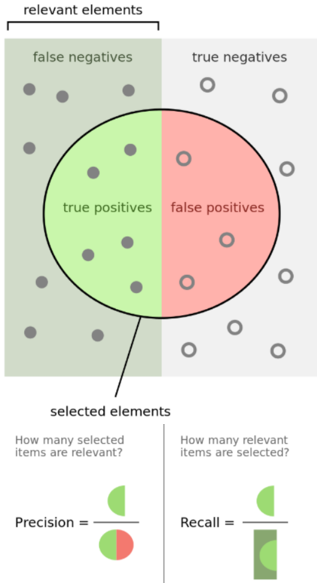

https://towardsdatascience.com/how-to-evaluate-your-machine-learning-models-with-python-code-5f8d2d8d945b